In [334]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [335]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [336]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [337]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 3289
Total Drives: 84218
Total Plays: 595530


In [338]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 83699


In [339]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [340]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [341]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr]
    })

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def calculate_five_factors_rating(team_stat_pack):
    return (.35 * team_stat_pack.OffSR) + (.25 * (team_stat_pack.OffER * team_stat_pack.YPP)) + (.15 * (team_stat_pack.FP / 50.0)) + (.15 * ((team_stat_pack.PPD + team_stat_pack.OppSR + team_stat_pack.OppEff)/3)) + (.10 * team_stat_pack.ExpTODiff)

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,1.15,-0.66,0.512424,-0.052568
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,1.81,0.66,0.564992,0.052568


In [342]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/3289] Getting game information for ESPN game_id: 400869090
[1/3289] Started processing game information for ESPN game_id: 400869090
[1/3289] Completed processing game information for ESPN game_id: 400869090
[1/3289] Aggreggating game_id 400869090 to master data copy
[2/3289] Getting game information for ESPN game_id: 400869421
[2/3289] Started processing game information for ESPN game_id: 400869421
[2/3289] Completed processing game information for ESPN game_id: 400869421
[2/3289] Aggreggating game_id 400869421 to master data copy
[3/3289] Getting game information for ESPN game_id: 400869257
[3/3289] Started processing game information for ESPN game_id: 400869257
[3/3289] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/3289] Getting game information for ESPN game_id: 400869502
[4/3289] Started processing game information for ESPN game_id: 400869502
[4/3289] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/3289] Getting game information for ES

[36/3289] Completed processing game information for ESPN game_id: 400869507
[36/3289] Aggreggating game_id 400869507 to master data copy
[37/3289] Getting game information for ESPN game_id: 400869260
[37/3289] Started processing game information for ESPN game_id: 400869260
[37/3289] Completed processing game information for ESPN game_id: 400869260
[37/3289] Aggreggating game_id 400869260 to master data copy
[38/3289] Getting game information for ESPN game_id: 400869509
[38/3289] Started processing game information for ESPN game_id: 400869509
[38/3289] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/3289] Getting game information for ESPN game_id: 400869267
[39/3289] Started processing game information for ESPN game_id: 400869267
[39/3289] Completed processing game information for ESPN game_id: 400869267
[39/3289] Aggreggating game_id 400869267 to master data copy
[40/3289] Getting game information for ESPN game_id: 400869428
[40/3289] Started processing game infor

[71/3289] Completed processing game information for ESPN game_id: 400868973
[71/3289] Aggreggating game_id 400868973 to master data copy
[72/3289] Getting game information for ESPN game_id: 400868957
[72/3289] Started processing game information for ESPN game_id: 400868957
[72/3289] Completed processing game information for ESPN game_id: 400868957
[72/3289] Aggreggating game_id 400868957 to master data copy
[73/3289] Getting game information for ESPN game_id: 400869624
[73/3289] Started processing game information for ESPN game_id: 400869624
[73/3289] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/3289] Getting game information for ESPN game_id: 400868969
[74/3289] Started processing game information for ESPN game_id: 400868969
[74/3289] Completed processing game information for ESPN game_id: 400868969
[74/3289] Aggreggating game_id 400868969 to master data copy
[75/3289] Getting game information for ESPN game_id: 400868887
[75/3289] Started processing game infor

[104/3289] Completed processing game information for ESPN game_id: 400869430
[104/3289] Aggreggating game_id 400869430 to master data copy
[105/3289] Getting game information for ESPN game_id: 400869513
[105/3289] Started processing game information for ESPN game_id: 400869513
[105/3289] Skipping checking game_id 400869513 bc one of the teams isn't FBS
[106/3289] Getting game information for ESPN game_id: 400869626
[106/3289] Started processing game information for ESPN game_id: 400869626
[106/3289] Skipping checking game_id 400869626 bc one of the teams isn't FBS
[107/3289] Getting game information for ESPN game_id: 400869184
[107/3289] Started processing game information for ESPN game_id: 400869184
[107/3289] Completed processing game information for ESPN game_id: 400869184
[107/3289] Aggreggating game_id 400869184 to master data copy
[108/3289] Getting game information for ESPN game_id: 400869101
[108/3289] Started processing game information for ESPN game_id: 400869101
[108/3289] C

[142/3289] Completed processing game information for ESPN game_id: 400868987
[142/3289] Aggreggating game_id 400868987 to master data copy
[143/3289] Getting game information for ESPN game_id: 400869612
[143/3289] Started processing game information for ESPN game_id: 400869612
[143/3289] Completed processing game information for ESPN game_id: 400869612
[143/3289] Aggreggating game_id 400869612 to master data copy
[144/3289] Getting game information for ESPN game_id: 400868981
[144/3289] Started processing game information for ESPN game_id: 400868981
[144/3289] Completed processing game information for ESPN game_id: 400868981
[144/3289] Aggreggating game_id 400868981 to master data copy
[145/3289] Getting game information for ESPN game_id: 400869357
[145/3289] Started processing game information for ESPN game_id: 400869357
[145/3289] Completed processing game information for ESPN game_id: 400869357
[145/3289] Aggreggating game_id 400869357 to master data copy
[146/3289] Getting game inf

[174/3289] Completed processing game information for ESPN game_id: 400869278
[174/3289] Aggreggating game_id 400869278 to master data copy
[175/3289] Getting game information for ESPN game_id: 400869192
[175/3289] Started processing game information for ESPN game_id: 400869192
[175/3289] Completed processing game information for ESPN game_id: 400869192
[175/3289] Aggreggating game_id 400869192 to master data copy
[176/3289] Getting game information for ESPN game_id: 400869281
[176/3289] Started processing game information for ESPN game_id: 400869281
[176/3289] Completed processing game information for ESPN game_id: 400869281
[176/3289] Aggreggating game_id 400869281 to master data copy
[177/3289] Getting game information for ESPN game_id: 400869519
[177/3289] Started processing game information for ESPN game_id: 400869519
[177/3289] Completed processing game information for ESPN game_id: 400869519
[177/3289] Aggreggating game_id 400869519 to master data copy
[178/3289] Getting game inf

[206/3289] Completed processing game information for ESPN game_id: 400869813
[206/3289] Aggreggating game_id 400869813 to master data copy
[207/3289] Getting game information for ESPN game_id: 400869445
[207/3289] Started processing game information for ESPN game_id: 400869445
[207/3289] Skipping checking game_id 400869445 bc one of the teams isn't FBS
[208/3289] Getting game information for ESPN game_id: 400869362
[208/3289] Started processing game information for ESPN game_id: 400869362
[208/3289] Completed processing game information for ESPN game_id: 400869362
[208/3289] Aggreggating game_id 400869362 to master data copy
[209/3289] Getting game information for ESPN game_id: 400868993
[209/3289] Started processing game information for ESPN game_id: 400868993
[209/3289] Completed processing game information for ESPN game_id: 400868993
[209/3289] Aggreggating game_id 400868993 to master data copy
[210/3289] Getting game information for ESPN game_id: 400868996
[210/3289] Started proces

[238/3289] Completed processing game information for ESPN game_id: 400869002
[238/3289] Aggreggating game_id 400869002 to master data copy
[239/3289] Getting game information for ESPN game_id: 400869634
[239/3289] Started processing game information for ESPN game_id: 400869634
[239/3289] Completed processing game information for ESPN game_id: 400869634
[239/3289] Aggreggating game_id 400869634 to master data copy
[240/3289] Getting game information for ESPN game_id: 400869363
[240/3289] Started processing game information for ESPN game_id: 400869363
[240/3289] Completed processing game information for ESPN game_id: 400869363
[240/3289] Aggreggating game_id 400869363 to master data copy
[241/3289] Getting game information for ESPN game_id: 400869204
[241/3289] Started processing game information for ESPN game_id: 400869204
[241/3289] Completed processing game information for ESPN game_id: 400869204
[241/3289] Aggreggating game_id 400869204 to master data copy
[242/3289] Getting game inf

[270/3289] Completed processing game information for ESPN game_id: 400869364
[270/3289] Aggreggating game_id 400869364 to master data copy
[271/3289] Getting game information for ESPN game_id: 400869816
[271/3289] Started processing game information for ESPN game_id: 400869816
[271/3289] Completed processing game information for ESPN game_id: 400869816
[271/3289] Aggreggating game_id 400869816 to master data copy
[272/3289] Getting game information for ESPN game_id: 400869365
[272/3289] Started processing game information for ESPN game_id: 400869365
[272/3289] Completed processing game information for ESPN game_id: 400869365
[272/3289] Aggreggating game_id 400869365 to master data copy
[273/3289] Getting game information for ESPN game_id: 400868913
[273/3289] Started processing game information for ESPN game_id: 400868913
[273/3289] Completed processing game information for ESPN game_id: 400868913
[273/3289] Aggreggating game_id 400868913 to master data copy
[274/3289] Getting game inf

[304/3289] Completed processing game information for ESPN game_id: 400869454
[304/3289] Aggreggating game_id 400869454 to master data copy
[305/3289] Getting game information for ESPN game_id: 400869294
[305/3289] Started processing game information for ESPN game_id: 400869294
[305/3289] Completed processing game information for ESPN game_id: 400869294
[305/3289] Aggreggating game_id 400869294 to master data copy
[306/3289] Getting game information for ESPN game_id: 400869296
[306/3289] Started processing game information for ESPN game_id: 400869296
[306/3289] Completed processing game information for ESPN game_id: 400869296
[306/3289] Aggreggating game_id 400869296 to master data copy
[307/3289] Getting game information for ESPN game_id: 400869127
[307/3289] Started processing game information for ESPN game_id: 400869127
[307/3289] Completed processing game information for ESPN game_id: 400869127
[307/3289] Aggreggating game_id 400869127 to master data copy
[308/3289] Getting game inf

[334/3289] Completed processing game information for ESPN game_id: 400869371
[334/3289] Aggreggating game_id 400869371 to master data copy
[335/3289] Getting game information for ESPN game_id: 400869010
[335/3289] Started processing game information for ESPN game_id: 400869010
[335/3289] Completed processing game information for ESPN game_id: 400869010
[335/3289] Aggreggating game_id 400869010 to master data copy
[336/3289] Getting game information for ESPN game_id: 400869374
[336/3289] Started processing game information for ESPN game_id: 400869374
[336/3289] Completed processing game information for ESPN game_id: 400869374
[336/3289] Aggreggating game_id 400869374 to master data copy
[337/3289] Getting game information for ESPN game_id: 400869014
[337/3289] Started processing game information for ESPN game_id: 400869014
[337/3289] Completed processing game information for ESPN game_id: 400869014
[337/3289] Aggreggating game_id 400869014 to master data copy
[338/3289] Getting game inf

[364/3289] Completed processing game information for ESPN game_id: 400869381
[364/3289] Aggreggating game_id 400869381 to master data copy
[365/3289] Getting game information for ESPN game_id: 400869021
[365/3289] Started processing game information for ESPN game_id: 400869021
[365/3289] Completed processing game information for ESPN game_id: 400869021
[365/3289] Aggreggating game_id 400869021 to master data copy
[366/3289] Getting game information for ESPN game_id: 400868951
[366/3289] Started processing game information for ESPN game_id: 400868951
[366/3289] Completed processing game information for ESPN game_id: 400868951
[366/3289] Aggreggating game_id 400868951 to master data copy
[367/3289] Getting game information for ESPN game_id: 400869458
[367/3289] Started processing game information for ESPN game_id: 400869458
[367/3289] Completed processing game information for ESPN game_id: 400869458
[367/3289] Aggreggating game_id 400869458 to master data copy
[368/3289] Getting game inf

[395/3289] Completed processing game information for ESPN game_id: 400869378
[395/3289] Aggreggating game_id 400869378 to master data copy
[396/3289] Getting game information for ESPN game_id: 400869722
[396/3289] Started processing game information for ESPN game_id: 400869722
[396/3289] Completed processing game information for ESPN game_id: 400869722
[396/3289] Aggreggating game_id 400869722 to master data copy
[397/3289] Getting game information for ESPN game_id: 400869134
[397/3289] Started processing game information for ESPN game_id: 400869134
[397/3289] Completed processing game information for ESPN game_id: 400869134
[397/3289] Aggreggating game_id 400869134 to master data copy
[398/3289] Getting game information for ESPN game_id: 400869130
[398/3289] Started processing game information for ESPN game_id: 400869130
[398/3289] Completed processing game information for ESPN game_id: 400869130
[398/3289] Aggreggating game_id 400869130 to master data copy
[399/3289] Getting game inf

[426/3289] Completed processing game information for ESPN game_id: 400869136
[426/3289] Aggreggating game_id 400869136 to master data copy
[427/3289] Getting game information for ESPN game_id: 400869219
[427/3289] Started processing game information for ESPN game_id: 400869219
[427/3289] Completed processing game information for ESPN game_id: 400869219
[427/3289] Aggreggating game_id 400869219 to master data copy
[428/3289] Getting game information for ESPN game_id: 400869672
[428/3289] Started processing game information for ESPN game_id: 400869672
[428/3289] Completed processing game information for ESPN game_id: 400869672
[428/3289] Aggreggating game_id 400869672 to master data copy
[429/3289] Getting game information for ESPN game_id: 400869827
[429/3289] Started processing game information for ESPN game_id: 400869827
[429/3289] Completed processing game information for ESPN game_id: 400869827
[429/3289] Aggreggating game_id 400869827 to master data copy
[430/3289] Getting game inf

[456/3289] Completed processing game information for ESPN game_id: 400869138
[456/3289] Aggreggating game_id 400869138 to master data copy
[457/3289] Getting game information for ESPN game_id: 400869223
[457/3289] Started processing game information for ESPN game_id: 400869223
[457/3289] Completed processing game information for ESPN game_id: 400869223
[457/3289] Aggreggating game_id 400869223 to master data copy
[458/3289] Getting game information for ESPN game_id: 400869222
[458/3289] Started processing game information for ESPN game_id: 400869222
[458/3289] Completed processing game information for ESPN game_id: 400869222
[458/3289] Aggreggating game_id 400869222 to master data copy
[459/3289] Getting game information for ESPN game_id: 400869467
[459/3289] Started processing game information for ESPN game_id: 400869467
[459/3289] Completed processing game information for ESPN game_id: 400869467
[459/3289] Aggreggating game_id 400869467 to master data copy
[460/3289] Getting game inf

[486/3289] Completed processing game information for ESPN game_id: 400869628
[486/3289] Aggreggating game_id 400869628 to master data copy
[487/3289] Getting game information for ESPN game_id: 400869314
[487/3289] Started processing game information for ESPN game_id: 400869314
[487/3289] Completed processing game information for ESPN game_id: 400869314
[487/3289] Aggreggating game_id 400869314 to master data copy
[488/3289] Getting game information for ESPN game_id: 400869546
[488/3289] Started processing game information for ESPN game_id: 400869546
[488/3289] Completed processing game information for ESPN game_id: 400869546
[488/3289] Aggreggating game_id 400869546 to master data copy
[489/3289] Getting game information for ESPN game_id: 400869831
[489/3289] Started processing game information for ESPN game_id: 400869831
[489/3289] Skipping checking game_id 400869831 bc one of the teams isn't FBS
[490/3289] Getting game information for ESPN game_id: 400869833
[490/3289] Started proces

[518/3289] Completed processing game information for ESPN game_id: 400869317
[518/3289] Aggreggating game_id 400869317 to master data copy
[519/3289] Getting game information for ESPN game_id: 400869835
[519/3289] Started processing game information for ESPN game_id: 400869835
[519/3289] Completed processing game information for ESPN game_id: 400869835
[519/3289] Aggreggating game_id 400869835 to master data copy
[520/3289] Getting game information for ESPN game_id: 400869145
[520/3289] Started processing game information for ESPN game_id: 400869145
[520/3289] Completed processing game information for ESPN game_id: 400869145
[520/3289] Aggreggating game_id 400869145 to master data copy
[521/3289] Getting game information for ESPN game_id: 400869548
[521/3289] Started processing game information for ESPN game_id: 400869548
[521/3289] Completed processing game information for ESPN game_id: 400869548
[521/3289] Aggreggating game_id 400869548 to master data copy
[522/3289] Getting game inf

[549/3289] Completed processing game information for ESPN game_id: 400869553
[549/3289] Aggreggating game_id 400869553 to master data copy
[550/3289] Getting game information for ESPN game_id: 400869147
[550/3289] Started processing game information for ESPN game_id: 400869147
[550/3289] Completed processing game information for ESPN game_id: 400869147
[550/3289] Aggreggating game_id 400869147 to master data copy
[551/3289] Getting game information for ESPN game_id: 400869837
[551/3289] Started processing game information for ESPN game_id: 400869837
[551/3289] Completed processing game information for ESPN game_id: 400869837
[551/3289] Aggreggating game_id 400869837 to master data copy
[552/3289] Getting game information for ESPN game_id: 400869836
[552/3289] Started processing game information for ESPN game_id: 400869836
[552/3289] Completed processing game information for ESPN game_id: 400869836
[552/3289] Aggreggating game_id 400869836 to master data copy
[553/3289] Getting game inf

[579/3289] Completed processing game information for ESPN game_id: 400869236
[579/3289] Aggreggating game_id 400869236 to master data copy
[580/3289] Getting game information for ESPN game_id: 400868954
[580/3289] Started processing game information for ESPN game_id: 400868954
[580/3289] Completed processing game information for ESPN game_id: 400868954
[580/3289] Aggreggating game_id 400868954 to master data copy
[581/3289] Getting game information for ESPN game_id: 400869045
[581/3289] Started processing game information for ESPN game_id: 400869045
[581/3289] Completed processing game information for ESPN game_id: 400869045
[581/3289] Aggreggating game_id 400869045 to master data copy
[582/3289] Getting game information for ESPN game_id: 400869630
[582/3289] Started processing game information for ESPN game_id: 400869630
[582/3289] Completed processing game information for ESPN game_id: 400869630
[582/3289] Aggreggating game_id 400869630 to master data copy
[583/3289] Getting game inf

[610/3289] Completed processing game information for ESPN game_id: 400869556
[610/3289] Aggreggating game_id 400869556 to master data copy
[611/3289] Getting game information for ESPN game_id: 400869047
[611/3289] Started processing game information for ESPN game_id: 400869047
[611/3289] Completed processing game information for ESPN game_id: 400869047
[611/3289] Aggreggating game_id 400869047 to master data copy
[612/3289] Getting game information for ESPN game_id: 400921256
[612/3289] Started processing game information for ESPN game_id: 400921256
[612/3289] Completed processing game information for ESPN game_id: 400921256
[612/3289] Aggreggating game_id 400921256 to master data copy
[613/3289] Getting game information for ESPN game_id: 400869841
[613/3289] Started processing game information for ESPN game_id: 400869841
[613/3289] Completed processing game information for ESPN game_id: 400869841
[613/3289] Aggreggating game_id 400869841 to master data copy
[614/3289] Getting game inf

[642/3289] Completed processing game information for ESPN game_id: 400868883
[642/3289] Aggreggating game_id 400868883 to master data copy
[643/3289] Getting game information for ESPN game_id: 400869631
[643/3289] Started processing game information for ESPN game_id: 400869631
[643/3289] Completed processing game information for ESPN game_id: 400869631
[643/3289] Aggreggating game_id 400869631 to master data copy
[644/3289] Getting game information for ESPN game_id: 400869054
[644/3289] Started processing game information for ESPN game_id: 400869054
[644/3289] Completed processing game information for ESPN game_id: 400869054
[644/3289] Aggreggating game_id 400869054 to master data copy
[645/3289] Getting game information for ESPN game_id: 400869557
[645/3289] Started processing game information for ESPN game_id: 400869557
[645/3289] Completed processing game information for ESPN game_id: 400869557
[645/3289] Aggreggating game_id 400869557 to master data copy
[646/3289] Getting game inf

[675/3289] Completed processing game information for ESPN game_id: 400869559
[675/3289] Aggreggating game_id 400869559 to master data copy
[676/3289] Getting game information for ESPN game_id: 400869407
[676/3289] Started processing game information for ESPN game_id: 400869407
[676/3289] Completed processing game information for ESPN game_id: 400869407
[676/3289] Aggreggating game_id 400869407 to master data copy
[677/3289] Getting game information for ESPN game_id: 400869242
[677/3289] Started processing game information for ESPN game_id: 400869242
[677/3289] Completed processing game information for ESPN game_id: 400869242
[677/3289] Aggreggating game_id 400869242 to master data copy
[678/3289] Getting game information for ESPN game_id: 400869050
[678/3289] Started processing game information for ESPN game_id: 400869050
[678/3289] Completed processing game information for ESPN game_id: 400869050
[678/3289] Aggreggating game_id 400869050 to master data copy
[679/3289] Getting game inf

[705/3289] Completed processing game information for ESPN game_id: 400869059
[705/3289] Aggreggating game_id 400869059 to master data copy
[706/3289] Getting game information for ESPN game_id: 400869414
[706/3289] Started processing game information for ESPN game_id: 400869414
[706/3289] Completed processing game information for ESPN game_id: 400869414
[706/3289] Aggreggating game_id 400869414 to master data copy
[707/3289] Getting game information for ESPN game_id: 400869694
[707/3289] Started processing game information for ESPN game_id: 400869694
[707/3289] Completed processing game information for ESPN game_id: 400869694
[707/3289] Aggreggating game_id 400869694 to master data copy
[708/3289] Getting game information for ESPN game_id: 400869494
[708/3289] Started processing game information for ESPN game_id: 400869494
[708/3289] Completed processing game information for ESPN game_id: 400869494
[708/3289] Aggreggating game_id 400869494 to master data copy
[709/3289] Getting game inf

[738/3289] Completed processing game information for ESPN game_id: 400869251
[738/3289] Aggreggating game_id 400869251 to master data copy
[739/3289] Getting game information for ESPN game_id: 400869062
[739/3289] Started processing game information for ESPN game_id: 400869062
[739/3289] Completed processing game information for ESPN game_id: 400869062
[739/3289] Aggreggating game_id 400869062 to master data copy
[740/3289] Getting game information for ESPN game_id: 400869565
[740/3289] Started processing game information for ESPN game_id: 400869565
[740/3289] Completed processing game information for ESPN game_id: 400869565
[740/3289] Aggreggating game_id 400869565 to master data copy
[741/3289] Getting game information for ESPN game_id: 400925661
[741/3289] Started processing game information for ESPN game_id: 400925661
[741/3289] Skipping checking game_id 400925661 bc one of the teams isn't FBS
[742/3289] Getting game information for ESPN game_id: 400869411
[742/3289] Started proces

[771/3289] Completed processing game information for ESPN game_id: 400869567
[771/3289] Aggreggating game_id 400869567 to master data copy
[772/3289] Getting game information for ESPN game_id: 400869167
[772/3289] Started processing game information for ESPN game_id: 400869167
[772/3289] Completed processing game information for ESPN game_id: 400869167
[772/3289] Aggreggating game_id 400869167 to master data copy
[773/3289] Getting game information for ESPN game_id: 400869701
[773/3289] Started processing game information for ESPN game_id: 400869701
[773/3289] Completed processing game information for ESPN game_id: 400869701
[773/3289] Aggreggating game_id 400869701 to master data copy
[774/3289] Getting game information for ESPN game_id: 400869501
[774/3289] Started processing game information for ESPN game_id: 400869501
[774/3289] Completed processing game information for ESPN game_id: 400869501
[774/3289] Aggreggating game_id 400869501 to master data copy
[775/3289] Getting game inf

[803/3289] Completed processing game information for ESPN game_id: 400869415
[803/3289] Aggreggating game_id 400869415 to master data copy
[804/3289] Getting game information for ESPN game_id: 400869419
[804/3289] Started processing game information for ESPN game_id: 400869419
[804/3289] Completed processing game information for ESPN game_id: 400869419
[804/3289] Aggreggating game_id 400869419 to master data copy
[805/3289] Getting game information for ESPN game_id: 400869169
[805/3289] Started processing game information for ESPN game_id: 400869169
[805/3289] Completed processing game information for ESPN game_id: 400869169
[805/3289] Aggreggating game_id 400869169 to master data copy
[806/3289] Getting game information for ESPN game_id: 400869074
[806/3289] Started processing game information for ESPN game_id: 400869074
[806/3289] Completed processing game information for ESPN game_id: 400869074
[806/3289] Aggreggating game_id 400869074 to master data copy
[807/3289] Getting game inf

[835/3289] Completed processing game information for ESPN game_id: 400938887
[835/3289] Aggreggating game_id 400938887 to master data copy
[836/3289] Getting game information for ESPN game_id: 400941786
[836/3289] Started processing game information for ESPN game_id: 400941786
[836/3289] Completed processing game information for ESPN game_id: 400941786
[836/3289] Aggreggating game_id 400941786 to master data copy
[837/3289] Getting game information for ESPN game_id: 400935257
[837/3289] Started processing game information for ESPN game_id: 400935257
[837/3289] Completed processing game information for ESPN game_id: 400935257
[837/3289] Aggreggating game_id 400935257 to master data copy
[838/3289] Getting game information for ESPN game_id: 400938591
[838/3289] Started processing game information for ESPN game_id: 400938591
[838/3289] Completed processing game information for ESPN game_id: 400938591
[838/3289] Aggreggating game_id 400938591 to master data copy
[839/3289] Getting game inf

[868/3289] Completed processing game information for ESPN game_id: 400935256
[868/3289] Aggreggating game_id 400935256 to master data copy
[869/3289] Getting game information for ESPN game_id: 400937449
[869/3289] Started processing game information for ESPN game_id: 400937449
[869/3289] Skipping checking game_id 400937449 bc one of the teams isn't FBS
[870/3289] Getting game information for ESPN game_id: 400937450
[870/3289] Started processing game information for ESPN game_id: 400937450
[870/3289] Skipping checking game_id 400937450 bc one of the teams isn't FBS
[871/3289] Getting game information for ESPN game_id: 400935254
[871/3289] Started processing game information for ESPN game_id: 400935254
[871/3289] Skipping checking game_id 400935254 bc one of the teams isn't FBS
[872/3289] Getting game information for ESPN game_id: 400945246
[872/3289] Started processing game information for ESPN game_id: 400945246
[872/3289] Skipping checking game_id 400945246 bc one of the teams isn't F

[904/3289] Completed processing game information for ESPN game_id: 400935238
[904/3289] Aggreggating game_id 400935238 to master data copy
[905/3289] Getting game information for ESPN game_id: 400945251
[905/3289] Started processing game information for ESPN game_id: 400945251
[905/3289] Skipping checking game_id 400945251 bc one of the teams isn't FBS
[906/3289] Getting game information for ESPN game_id: 400934488
[906/3289] Started processing game information for ESPN game_id: 400934488
[906/3289] Skipping checking game_id 400934488 bc one of the teams isn't FBS
[907/3289] Getting game information for ESPN game_id: 400933827
[907/3289] Started processing game information for ESPN game_id: 400933827
[907/3289] Completed processing game information for ESPN game_id: 400933827
[907/3289] Aggreggating game_id 400933827 to master data copy
[908/3289] Getting game information for ESPN game_id: 400945247
[908/3289] Started processing game information for ESPN game_id: 400945247
[908/3289] S

[941/3289] Completed processing game information for ESPN game_id: 400935262
[941/3289] Aggreggating game_id 400935262 to master data copy
[942/3289] Getting game information for ESPN game_id: 400938605
[942/3289] Started processing game information for ESPN game_id: 400938605
[942/3289] Completed processing game information for ESPN game_id: 400938605
[942/3289] Aggreggating game_id 400938605 to master data copy
[943/3289] Getting game information for ESPN game_id: 400944894
[943/3289] Started processing game information for ESPN game_id: 400944894
[943/3289] Skipping checking game_id 400944894 bc one of the teams isn't FBS
[944/3289] Getting game information for ESPN game_id: 400944895
[944/3289] Started processing game information for ESPN game_id: 400944895
[944/3289] Skipping checking game_id 400944895 bc one of the teams isn't FBS
[945/3289] Getting game information for ESPN game_id: 400944896
[945/3289] Started processing game information for ESPN game_id: 400944896
[945/3289] S

[978/3289] Completed processing game information for ESPN game_id: 400933850
[978/3289] Aggreggating game_id 400933850 to master data copy
[979/3289] Getting game information for ESPN game_id: 400933843
[979/3289] Started processing game information for ESPN game_id: 400933843
[979/3289] Completed processing game information for ESPN game_id: 400933843
[979/3289] Aggreggating game_id 400933843 to master data copy
[980/3289] Getting game information for ESPN game_id: 400934502
[980/3289] Started processing game information for ESPN game_id: 400934502
[980/3289] Completed processing game information for ESPN game_id: 400934502
[980/3289] Aggreggating game_id 400934502 to master data copy
[981/3289] Getting game information for ESPN game_id: 400933847
[981/3289] Started processing game information for ESPN game_id: 400933847
[981/3289] Skipping checking game_id 400933847 bc one of the teams isn't FBS
[982/3289] Getting game information for ESPN game_id: 400933845
[982/3289] Started proces

[1013/3289] Completed processing game information for ESPN game_id: 400937469
[1013/3289] Aggreggating game_id 400937469 to master data copy
[1014/3289] Getting game information for ESPN game_id: 400934510
[1014/3289] Started processing game information for ESPN game_id: 400934510
[1014/3289] Completed processing game information for ESPN game_id: 400934510
[1014/3289] Aggreggating game_id 400934510 to master data copy
[1015/3289] Getting game information for ESPN game_id: 400933856
[1015/3289] Started processing game information for ESPN game_id: 400933856
[1015/3289] Completed processing game information for ESPN game_id: 400933856
[1015/3289] Aggreggating game_id 400933856 to master data copy
[1016/3289] Getting game information for ESPN game_id: 400935357
[1016/3289] Started processing game information for ESPN game_id: 400935357
[1016/3289] Skipping checking game_id 400935357 bc one of the teams isn't FBS
[1017/3289] Getting game information for ESPN game_id: 400935353
[1017/3289]

[1048/3289] Completed processing game information for ESPN game_id: 400935355
[1048/3289] Aggreggating game_id 400935355 to master data copy
[1049/3289] Getting game information for ESPN game_id: 400933863
[1049/3289] Started processing game information for ESPN game_id: 400933863
[1049/3289] Completed processing game information for ESPN game_id: 400933863
[1049/3289] Aggreggating game_id 400933863 to master data copy
[1050/3289] Getting game information for ESPN game_id: 400944837
[1050/3289] Started processing game information for ESPN game_id: 400944837
[1050/3289] Completed processing game information for ESPN game_id: 400944837
[1050/3289] Aggreggating game_id 400944837 to master data copy
[1051/3289] Getting game information for ESPN game_id: 400937461
[1051/3289] Started processing game information for ESPN game_id: 400937461
[1051/3289] Completed processing game information for ESPN game_id: 400937461
[1051/3289] Aggreggating game_id 400937461 to master data copy
[1052/3289] G

[1079/3289] Completed processing game information for ESPN game_id: 400933871
[1079/3289] Aggreggating game_id 400933871 to master data copy
[1080/3289] Getting game information for ESPN game_id: 400935359
[1080/3289] Started processing game information for ESPN game_id: 400935359
[1080/3289] Completed processing game information for ESPN game_id: 400935359
[1080/3289] Aggreggating game_id 400935359 to master data copy
[1081/3289] Getting game information for ESPN game_id: 400941804
[1081/3289] Started processing game information for ESPN game_id: 400941804
[1081/3289] Completed processing game information for ESPN game_id: 400941804
[1081/3289] Aggreggating game_id 400941804 to master data copy
[1082/3289] Getting game information for ESPN game_id: 400944901
[1082/3289] Started processing game information for ESPN game_id: 400944901
[1082/3289] Completed processing game information for ESPN game_id: 400944901
[1082/3289] Aggreggating game_id 400944901 to master data copy
[1083/3289] G

[1111/3289] Completed processing game information for ESPN game_id: 400938619
[1111/3289] Aggreggating game_id 400938619 to master data copy
[1112/3289] Getting game information for ESPN game_id: 400941805
[1112/3289] Started processing game information for ESPN game_id: 400941805
[1112/3289] Skipping checking game_id 400941805 bc one of the teams isn't FBS
[1113/3289] Getting game information for ESPN game_id: 400934575
[1113/3289] Started processing game information for ESPN game_id: 400934575
[1113/3289] Completed processing game information for ESPN game_id: 400934575
[1113/3289] Aggreggating game_id 400934575 to master data copy
[1114/3289] Getting game information for ESPN game_id: 400935278
[1114/3289] Started processing game information for ESPN game_id: 400935278
[1114/3289] Completed processing game information for ESPN game_id: 400935278
[1114/3289] Aggreggating game_id 400935278 to master data copy
[1115/3289] Getting game information for ESPN game_id: 400935281
[1115/3289]

[1143/3289] Completed processing game information for ESPN game_id: 400941809
[1143/3289] Aggreggating game_id 400941809 to master data copy
[1144/3289] Getting game information for ESPN game_id: 400933876
[1144/3289] Started processing game information for ESPN game_id: 400933876
[1144/3289] Completed processing game information for ESPN game_id: 400933876
[1144/3289] Aggreggating game_id 400933876 to master data copy
[1145/3289] Getting game information for ESPN game_id: 400935366
[1145/3289] Started processing game information for ESPN game_id: 400935366
[1145/3289] Completed processing game information for ESPN game_id: 400935366
[1145/3289] Aggreggating game_id 400935366 to master data copy
[1146/3289] Getting game information for ESPN game_id: 400944845
[1146/3289] Started processing game information for ESPN game_id: 400944845
[1146/3289] Completed processing game information for ESPN game_id: 400944845
[1146/3289] Aggreggating game_id 400944845 to master data copy
[1147/3289] G

[1173/3289] Completed processing game information for ESPN game_id: 400944846
[1173/3289] Aggreggating game_id 400944846 to master data copy
[1174/3289] Getting game information for ESPN game_id: 400937487
[1174/3289] Started processing game information for ESPN game_id: 400937487
[1174/3289] Completed processing game information for ESPN game_id: 400937487
[1174/3289] Aggreggating game_id 400937487 to master data copy
[1175/3289] Getting game information for ESPN game_id: 400941814
[1175/3289] Started processing game information for ESPN game_id: 400941814
[1175/3289] Completed processing game information for ESPN game_id: 400941814
[1175/3289] Aggreggating game_id 400941814 to master data copy
[1176/3289] Getting game information for ESPN game_id: 400945267
[1176/3289] Started processing game information for ESPN game_id: 400945267
[1176/3289] Completed processing game information for ESPN game_id: 400945267
[1176/3289] Aggreggating game_id 400945267 to master data copy
[1177/3289] G

[1206/3289] Completed processing game information for ESPN game_id: 400935290
[1206/3289] Aggreggating game_id 400935290 to master data copy
[1207/3289] Getting game information for ESPN game_id: 400933883
[1207/3289] Started processing game information for ESPN game_id: 400933883
[1207/3289] Completed processing game information for ESPN game_id: 400933883
[1207/3289] Aggreggating game_id 400933883 to master data copy
[1208/3289] Getting game information for ESPN game_id: 400945268
[1208/3289] Started processing game information for ESPN game_id: 400945268
[1208/3289] Completed processing game information for ESPN game_id: 400945268
[1208/3289] Aggreggating game_id 400945268 to master data copy
[1209/3289] Getting game information for ESPN game_id: 400944848
[1209/3289] Started processing game information for ESPN game_id: 400944848
[1209/3289] Skipping checking game_id 400944848 bc one of the teams isn't FBS
[1210/3289] Getting game information for ESPN game_id: 400938627
[1210/3289]

[1237/3289] Completed processing game information for ESPN game_id: 400937497
[1237/3289] Aggreggating game_id 400937497 to master data copy
[1238/3289] Getting game information for ESPN game_id: 400941821
[1238/3289] Started processing game information for ESPN game_id: 400941821
[1238/3289] Completed processing game information for ESPN game_id: 400941821
[1238/3289] Aggreggating game_id 400941821 to master data copy
[1239/3289] Getting game information for ESPN game_id: 400934567
[1239/3289] Started processing game information for ESPN game_id: 400934567
[1239/3289] Completed processing game information for ESPN game_id: 400934567
[1239/3289] Aggreggating game_id 400934567 to master data copy
[1240/3289] Getting game information for ESPN game_id: 400933891
[1240/3289] Started processing game information for ESPN game_id: 400933891
[1240/3289] Completed processing game information for ESPN game_id: 400933891
[1240/3289] Aggreggating game_id 400933891 to master data copy
[1241/3289] G

[1268/3289] Completed processing game information for ESPN game_id: 400944855
[1268/3289] Aggreggating game_id 400944855 to master data copy
[1269/3289] Getting game information for ESPN game_id: 400938635
[1269/3289] Started processing game information for ESPN game_id: 400938635
[1269/3289] Completed processing game information for ESPN game_id: 400938635
[1269/3289] Aggreggating game_id 400938635 to master data copy
[1270/3289] Getting game information for ESPN game_id: 400933887
[1270/3289] Started processing game information for ESPN game_id: 400933887
[1270/3289] Completed processing game information for ESPN game_id: 400933887
[1270/3289] Aggreggating game_id 400933887 to master data copy
[1271/3289] Getting game information for ESPN game_id: 400944854
[1271/3289] Started processing game information for ESPN game_id: 400944854
[1271/3289] Completed processing game information for ESPN game_id: 400944854
[1271/3289] Aggreggating game_id 400944854 to master data copy
[1272/3289] G

[1298/3289] Completed processing game information for ESPN game_id: 400934535
[1298/3289] Aggreggating game_id 400934535 to master data copy
[1299/3289] Getting game information for ESPN game_id: 400934568
[1299/3289] Started processing game information for ESPN game_id: 400934568
[1299/3289] Completed processing game information for ESPN game_id: 400934568
[1299/3289] Aggreggating game_id 400934568 to master data copy
[1300/3289] Getting game information for ESPN game_id: 400941827
[1300/3289] Started processing game information for ESPN game_id: 400941827
[1300/3289] Completed processing game information for ESPN game_id: 400941827
[1300/3289] Aggreggating game_id 400941827 to master data copy
[1301/3289] Getting game information for ESPN game_id: 400944999
[1301/3289] Started processing game information for ESPN game_id: 400944999
[1301/3289] Completed processing game information for ESPN game_id: 400944999
[1301/3289] Aggreggating game_id 400944999 to master data copy
[1302/3289] G

[1329/3289] Completed processing game information for ESPN game_id: 400945281
[1329/3289] Aggreggating game_id 400945281 to master data copy
[1330/3289] Getting game information for ESPN game_id: 400938638
[1330/3289] Started processing game information for ESPN game_id: 400938638
[1330/3289] Completed processing game information for ESPN game_id: 400938638
[1330/3289] Aggreggating game_id 400938638 to master data copy
[1331/3289] Getting game information for ESPN game_id: 400941828
[1331/3289] Started processing game information for ESPN game_id: 400941828
[1331/3289] Completed processing game information for ESPN game_id: 400941828
[1331/3289] Aggreggating game_id 400941828 to master data copy
[1332/3289] Getting game information for ESPN game_id: 400938640
[1332/3289] Started processing game information for ESPN game_id: 400938640
[1332/3289] Completed processing game information for ESPN game_id: 400938640
[1332/3289] Aggreggating game_id 400938640 to master data copy
[1333/3289] G

[1359/3289] Completed processing game information for ESPN game_id: 400934538
[1359/3289] Aggreggating game_id 400934538 to master data copy
[1360/3289] Getting game information for ESPN game_id: 400937507
[1360/3289] Started processing game information for ESPN game_id: 400937507
[1360/3289] Completed processing game information for ESPN game_id: 400937507
[1360/3289] Aggreggating game_id 400937507 to master data copy
[1361/3289] Getting game information for ESPN game_id: 400937509
[1361/3289] Started processing game information for ESPN game_id: 400937509
[1361/3289] Completed processing game information for ESPN game_id: 400937509
[1361/3289] Aggreggating game_id 400937509 to master data copy
[1362/3289] Getting game information for ESPN game_id: 400935308
[1362/3289] Started processing game information for ESPN game_id: 400935308
[1362/3289] Completed processing game information for ESPN game_id: 400935308
[1362/3289] Aggreggating game_id 400935308 to master data copy
[1363/3289] G

[1390/3289] Completed processing game information for ESPN game_id: 400933899
[1390/3289] Aggreggating game_id 400933899 to master data copy
[1391/3289] Getting game information for ESPN game_id: 400945285
[1391/3289] Started processing game information for ESPN game_id: 400945285
[1391/3289] Completed processing game information for ESPN game_id: 400945285
[1391/3289] Aggreggating game_id 400945285 to master data copy
[1392/3289] Getting game information for ESPN game_id: 400935395
[1392/3289] Started processing game information for ESPN game_id: 400935395
[1392/3289] Completed processing game information for ESPN game_id: 400935395
[1392/3289] Aggreggating game_id 400935395 to master data copy
[1393/3289] Getting game information for ESPN game_id: 400938648
[1393/3289] Started processing game information for ESPN game_id: 400938648
[1393/3289] Completed processing game information for ESPN game_id: 400938648
[1393/3289] Aggreggating game_id 400938648 to master data copy
[1394/3289] G

[1421/3289] Completed processing game information for ESPN game_id: 400941833
[1421/3289] Aggreggating game_id 400941833 to master data copy
[1422/3289] Getting game information for ESPN game_id: 400937511
[1422/3289] Started processing game information for ESPN game_id: 400937511
[1422/3289] Completed processing game information for ESPN game_id: 400937511
[1422/3289] Aggreggating game_id 400937511 to master data copy
[1423/3289] Getting game information for ESPN game_id: 400938653
[1423/3289] Started processing game information for ESPN game_id: 400938653
[1423/3289] Completed processing game information for ESPN game_id: 400938653
[1423/3289] Aggreggating game_id 400938653 to master data copy
[1424/3289] Getting game information for ESPN game_id: 400944867
[1424/3289] Started processing game information for ESPN game_id: 400944867
[1424/3289] Completed processing game information for ESPN game_id: 400944867
[1424/3289] Aggreggating game_id 400944867 to master data copy
[1425/3289] G

[1451/3289] Completed processing game information for ESPN game_id: 400941836
[1451/3289] Aggreggating game_id 400941836 to master data copy
[1452/3289] Getting game information for ESPN game_id: 400934545
[1452/3289] Started processing game information for ESPN game_id: 400934545
[1452/3289] Completed processing game information for ESPN game_id: 400934545
[1452/3289] Aggreggating game_id 400934545 to master data copy
[1453/3289] Getting game information for ESPN game_id: 400938652
[1453/3289] Started processing game information for ESPN game_id: 400938652
[1453/3289] Completed processing game information for ESPN game_id: 400938652
[1453/3289] Aggreggating game_id 400938652 to master data copy
[1454/3289] Getting game information for ESPN game_id: 400933910
[1454/3289] Started processing game information for ESPN game_id: 400933910
[1454/3289] Completed processing game information for ESPN game_id: 400933910
[1454/3289] Aggreggating game_id 400933910 to master data copy
[1455/3289] G

[1481/3289] Completed processing game information for ESPN game_id: 400934548
[1481/3289] Aggreggating game_id 400934548 to master data copy
[1482/3289] Getting game information for ESPN game_id: 400935405
[1482/3289] Started processing game information for ESPN game_id: 400935405
[1482/3289] Completed processing game information for ESPN game_id: 400935405
[1482/3289] Aggreggating game_id 400935405 to master data copy
[1483/3289] Getting game information for ESPN game_id: 400941842
[1483/3289] Started processing game information for ESPN game_id: 400941842
[1483/3289] Completed processing game information for ESPN game_id: 400941842
[1483/3289] Aggreggating game_id 400941842 to master data copy
[1484/3289] Getting game information for ESPN game_id: 400933914
[1484/3289] Started processing game information for ESPN game_id: 400933914
[1484/3289] Completed processing game information for ESPN game_id: 400933914
[1484/3289] Aggreggating game_id 400933914 to master data copy
[1485/3289] G

[1511/3289] Completed processing game information for ESPN game_id: 400941843
[1511/3289] Aggreggating game_id 400941843 to master data copy
[1512/3289] Getting game information for ESPN game_id: 400938660
[1512/3289] Started processing game information for ESPN game_id: 400938660
[1512/3289] Completed processing game information for ESPN game_id: 400938660
[1512/3289] Aggreggating game_id 400938660 to master data copy
[1513/3289] Getting game information for ESPN game_id: 400938655
[1513/3289] Started processing game information for ESPN game_id: 400938655
[1513/3289] Completed processing game information for ESPN game_id: 400938655
[1513/3289] Aggreggating game_id 400938655 to master data copy
[1514/3289] Getting game information for ESPN game_id: 400933916
[1514/3289] Started processing game information for ESPN game_id: 400933916
[1514/3289] Completed processing game information for ESPN game_id: 400933916
[1514/3289] Aggreggating game_id 400933916 to master data copy
[1515/3289] G

[1542/3289] Completed processing game information for ESPN game_id: 400934554
[1542/3289] Aggreggating game_id 400934554 to master data copy
[1543/3289] Getting game information for ESPN game_id: 400935410
[1543/3289] Started processing game information for ESPN game_id: 400935410
[1543/3289] Completed processing game information for ESPN game_id: 400935410
[1543/3289] Aggreggating game_id 400935410 to master data copy
[1544/3289] Getting game information for ESPN game_id: 400937523
[1544/3289] Started processing game information for ESPN game_id: 400937523
[1544/3289] Skipping checking game_id 400937523 bc one of the teams isn't FBS
[1545/3289] Getting game information for ESPN game_id: 400937521
[1545/3289] Started processing game information for ESPN game_id: 400937521
[1545/3289] Skipping checking game_id 400937521 bc one of the teams isn't FBS
[1546/3289] Getting game information for ESPN game_id: 400937528
[1546/3289] Started processing game information for ESPN game_id: 40093752

[1574/3289] Completed processing game information for ESPN game_id: 400934571
[1574/3289] Aggreggating game_id 400934571 to master data copy
[1575/3289] Getting game information for ESPN game_id: 400933926
[1575/3289] Started processing game information for ESPN game_id: 400933926
[1575/3289] Completed processing game information for ESPN game_id: 400933926
[1575/3289] Aggreggating game_id 400933926 to master data copy
[1576/3289] Getting game information for ESPN game_id: 400938664
[1576/3289] Started processing game information for ESPN game_id: 400938664
[1576/3289] Completed processing game information for ESPN game_id: 400938664
[1576/3289] Aggreggating game_id 400938664 to master data copy
[1577/3289] Getting game information for ESPN game_id: 400938662
[1577/3289] Started processing game information for ESPN game_id: 400938662
[1577/3289] Completed processing game information for ESPN game_id: 400938662
[1577/3289] Aggreggating game_id 400938662 to master data copy
[1578/3289] G

[1604/3289] Completed processing game information for ESPN game_id: 400937530
[1604/3289] Aggreggating game_id 400937530 to master data copy
[1605/3289] Getting game information for ESPN game_id: 400934557
[1605/3289] Started processing game information for ESPN game_id: 400934557
[1605/3289] Completed processing game information for ESPN game_id: 400934557
[1605/3289] Aggreggating game_id 400934557 to master data copy
[1606/3289] Getting game information for ESPN game_id: 400935326
[1606/3289] Started processing game information for ESPN game_id: 400935326
[1606/3289] Completed processing game information for ESPN game_id: 400935326
[1606/3289] Aggreggating game_id 400935326 to master data copy
[1607/3289] Getting game information for ESPN game_id: 400935422
[1607/3289] Started processing game information for ESPN game_id: 400935422
[1607/3289] Completed processing game information for ESPN game_id: 400935422
[1607/3289] Aggreggating game_id 400935422 to master data copy
[1608/3289] G

[1634/3289] Completed processing game information for ESPN game_id: 400935423
[1634/3289] Aggreggating game_id 400935423 to master data copy
[1635/3289] Getting game information for ESPN game_id: 400941853
[1635/3289] Started processing game information for ESPN game_id: 400941853
[1635/3289] Completed processing game information for ESPN game_id: 400941853
[1635/3289] Aggreggating game_id 400941853 to master data copy
[1636/3289] Getting game information for ESPN game_id: 400944882
[1636/3289] Started processing game information for ESPN game_id: 400944882
[1636/3289] Skipping checking game_id 400944882 bc one of the teams isn't FBS
[1637/3289] Getting game information for ESPN game_id: 400933938
[1637/3289] Started processing game information for ESPN game_id: 400933938
[1637/3289] Completed processing game information for ESPN game_id: 400933938
[1637/3289] Aggreggating game_id 400933938 to master data copy
[1638/3289] Getting game information for ESPN game_id: 400935328
[1638/3289]

[1665/3289] Completed processing game information for ESPN game_id: 400955156
[1665/3289] Aggreggating game_id 400955156 to master data copy
[1666/3289] Getting game information for ESPN game_id: 400934572
[1666/3289] Started processing game information for ESPN game_id: 400934572
[1666/3289] Completed processing game information for ESPN game_id: 400934572
[1666/3289] Aggreggating game_id 400934572 to master data copy
[1667/3289] Getting game information for ESPN game_id: 401013357
[1667/3289] Started processing game information for ESPN game_id: 401013357
[1667/3289] Skipping checking game_id 401013357 bc one of the teams isn't FBS
[1668/3289] Getting game information for ESPN game_id: 401014972
[1668/3289] Started processing game information for ESPN game_id: 401014972
[1668/3289] Skipping checking game_id 401014972 bc one of the teams isn't FBS
[1669/3289] Getting game information for ESPN game_id: 401022510
[1669/3289] Started processing game information for ESPN game_id: 40102251

[1700/3289] Completed processing game information for ESPN game_id: 401012872
[1700/3289] Aggreggating game_id 401012872 to master data copy
[1701/3289] Getting game information for ESPN game_id: 401012256
[1701/3289] Started processing game information for ESPN game_id: 401012256
[1701/3289] Completed processing game information for ESPN game_id: 401012256
[1701/3289] Aggreggating game_id 401012256 to master data copy
[1702/3289] Getting game information for ESPN game_id: 401013088
[1702/3289] Started processing game information for ESPN game_id: 401013088
[1702/3289] Skipping checking game_id 401013088 bc one of the teams isn't FBS
[1703/3289] Getting game information for ESPN game_id: 401013090
[1703/3289] Started processing game information for ESPN game_id: 401013090
[1703/3289] Skipping checking game_id 401013090 bc one of the teams isn't FBS
[1704/3289] Getting game information for ESPN game_id: 401013087
[1704/3289] Started processing game information for ESPN game_id: 40101308

[1740/3289] Completed processing game information for ESPN game_id: 401012259
[1740/3289] Aggreggating game_id 401012259 to master data copy
[1741/3289] Getting game information for ESPN game_id: 401012254
[1741/3289] Started processing game information for ESPN game_id: 401012254
[1741/3289] Skipping checking game_id 401012254 bc one of the teams isn't FBS
[1742/3289] Getting game information for ESPN game_id: 401014980
[1742/3289] Started processing game information for ESPN game_id: 401014980
[1742/3289] Skipping checking game_id 401014980 bc one of the teams isn't FBS
[1743/3289] Getting game information for ESPN game_id: 401014976
[1743/3289] Started processing game information for ESPN game_id: 401014976
[1743/3289] Completed processing game information for ESPN game_id: 401014976
[1743/3289] Aggreggating game_id 401014976 to master data copy
[1744/3289] Getting game information for ESPN game_id: 401012246
[1744/3289] Started processing game information for ESPN game_id: 40101224

[1776/3289] Completed processing game information for ESPN game_id: 401019479
[1776/3289] Aggreggating game_id 401019479 to master data copy
[1777/3289] Getting game information for ESPN game_id: 401012821
[1777/3289] Started processing game information for ESPN game_id: 401012821
[1777/3289] Completed processing game information for ESPN game_id: 401012821
[1777/3289] Aggreggating game_id 401012821 to master data copy
[1778/3289] Getting game information for ESPN game_id: 401012268
[1778/3289] Started processing game information for ESPN game_id: 401012268
[1778/3289] Completed processing game information for ESPN game_id: 401012268
[1778/3289] Aggreggating game_id 401012268 to master data copy
[1779/3289] Getting game information for ESPN game_id: 401019478
[1779/3289] Started processing game information for ESPN game_id: 401019478
[1779/3289] Completed processing game information for ESPN game_id: 401019478
[1779/3289] Aggreggating game_id 401019478 to master data copy
[1780/3289] G

[1811/3289] Completed processing game information for ESPN game_id: 401013329
[1811/3289] Aggreggating game_id 401013329 to master data copy
[1812/3289] Getting game information for ESPN game_id: 401012262
[1812/3289] Started processing game information for ESPN game_id: 401012262
[1812/3289] Skipping checking game_id 401012262 bc one of the teams isn't FBS
[1813/3289] Getting game information for ESPN game_id: 401014992
[1813/3289] Started processing game information for ESPN game_id: 401014992
[1813/3289] Skipping checking game_id 401014992 bc one of the teams isn't FBS
[1814/3289] Getting game information for ESPN game_id: 401012263
[1814/3289] Started processing game information for ESPN game_id: 401012263
[1814/3289] Completed processing game information for ESPN game_id: 401012263
[1814/3289] Aggreggating game_id 401012263 to master data copy
[1815/3289] Getting game information for ESPN game_id: 401012261
[1815/3289] Started processing game information for ESPN game_id: 40101226

[1844/3289] Completed processing game information for ESPN game_id: 401012281
[1844/3289] Aggreggating game_id 401012281 to master data copy
[1845/3289] Getting game information for ESPN game_id: 401012853
[1845/3289] Started processing game information for ESPN game_id: 401012853
[1845/3289] Completed processing game information for ESPN game_id: 401012853
[1845/3289] Aggreggating game_id 401012853 to master data copy
[1846/3289] Getting game information for ESPN game_id: 401012874
[1846/3289] Started processing game information for ESPN game_id: 401012874
[1846/3289] Completed processing game information for ESPN game_id: 401012874
[1846/3289] Aggreggating game_id 401012874 to master data copy
[1847/3289] Getting game information for ESPN game_id: 401012276
[1847/3289] Started processing game information for ESPN game_id: 401012276
[1847/3289] Skipping checking game_id 401012276 bc one of the teams isn't FBS
[1848/3289] Getting game information for ESPN game_id: 401013368
[1848/3289]

[1881/3289] Completed processing game information for ESPN game_id: 401012277
[1881/3289] Aggreggating game_id 401012277 to master data copy
[1882/3289] Getting game information for ESPN game_id: 401012744
[1882/3289] Started processing game information for ESPN game_id: 401012744
[1882/3289] Completed processing game information for ESPN game_id: 401012744
[1882/3289] Aggreggating game_id 401012744 to master data copy
[1883/3289] Getting game information for ESPN game_id: 401013113
[1883/3289] Started processing game information for ESPN game_id: 401013113
[1883/3289] Completed processing game information for ESPN game_id: 401013113
[1883/3289] Aggreggating game_id 401013113 to master data copy
[1884/3289] Getting game information for ESPN game_id: 401012864
[1884/3289] Started processing game information for ESPN game_id: 401012864
[1884/3289] Skipping checking game_id 401012864 bc one of the teams isn't FBS
[1885/3289] Getting game information for ESPN game_id: 401012282
[1885/3289]

[1912/3289] Completed processing game information for ESPN game_id: 401020685
[1912/3289] Aggreggating game_id 401020685 to master data copy
[1913/3289] Getting game information for ESPN game_id: 401019495
[1913/3289] Started processing game information for ESPN game_id: 401019495
[1913/3289] Completed processing game information for ESPN game_id: 401019495
[1913/3289] Aggreggating game_id 401019495 to master data copy
[1914/3289] Getting game information for ESPN game_id: 401013125
[1914/3289] Started processing game information for ESPN game_id: 401013125
[1914/3289] Completed processing game information for ESPN game_id: 401013125
[1914/3289] Aggreggating game_id 401013125 to master data copy
[1915/3289] Getting game information for ESPN game_id: 401013123
[1915/3289] Started processing game information for ESPN game_id: 401013123
[1915/3289] Completed processing game information for ESPN game_id: 401013123
[1915/3289] Aggreggating game_id 401013123 to master data copy
[1916/3289] G

[1944/3289] Completed processing game information for ESPN game_id: 401013066
[1944/3289] Aggreggating game_id 401013066 to master data copy
[1945/3289] Getting game information for ESPN game_id: 401012286
[1945/3289] Started processing game information for ESPN game_id: 401012286
[1945/3289] Completed processing game information for ESPN game_id: 401012286
[1945/3289] Aggreggating game_id 401012286 to master data copy
[1946/3289] Getting game information for ESPN game_id: 401021664
[1946/3289] Started processing game information for ESPN game_id: 401021664
[1946/3289] Completed processing game information for ESPN game_id: 401021664
[1946/3289] Aggreggating game_id 401021664 to master data copy
[1947/3289] Getting game information for ESPN game_id: 401021662
[1947/3289] Started processing game information for ESPN game_id: 401021662
[1947/3289] Completed processing game information for ESPN game_id: 401021662
[1947/3289] Aggreggating game_id 401021662 to master data copy
[1948/3289] G

[1976/3289] Completed processing game information for ESPN game_id: 401021668
[1976/3289] Aggreggating game_id 401021668 to master data copy
[1977/3289] Getting game information for ESPN game_id: 401020687
[1977/3289] Started processing game information for ESPN game_id: 401020687
[1977/3289] Completed processing game information for ESPN game_id: 401020687
[1977/3289] Aggreggating game_id 401020687 to master data copy
[1978/3289] Getting game information for ESPN game_id: 401013060
[1978/3289] Started processing game information for ESPN game_id: 401013060
[1978/3289] Completed processing game information for ESPN game_id: 401013060
[1978/3289] Aggreggating game_id 401013060 to master data copy
[1979/3289] Getting game information for ESPN game_id: 401021665
[1979/3289] Started processing game information for ESPN game_id: 401021665
[1979/3289] Completed processing game information for ESPN game_id: 401021665
[1979/3289] Aggreggating game_id 401021665 to master data copy
[1980/3289] G

[2009/3289] Completed processing game information for ESPN game_id: 401013347
[2009/3289] Aggreggating game_id 401013347 to master data copy
[2010/3289] Getting game information for ESPN game_id: 401015005
[2010/3289] Started processing game information for ESPN game_id: 401015005
[2010/3289] Completed processing game information for ESPN game_id: 401015005
[2010/3289] Aggreggating game_id 401015005 to master data copy
[2011/3289] Getting game information for ESPN game_id: 401012758
[2011/3289] Started processing game information for ESPN game_id: 401012758
[2011/3289] Completed processing game information for ESPN game_id: 401012758
[2011/3289] Aggreggating game_id 401012758 to master data copy
[2012/3289] Getting game information for ESPN game_id: 401015004
[2012/3289] Started processing game information for ESPN game_id: 401015004
[2012/3289] Completed processing game information for ESPN game_id: 401015004
[2012/3289] Aggreggating game_id 401015004 to master data copy
[2013/3289] G

[2039/3289] Completed processing game information for ESPN game_id: 401020755
[2039/3289] Aggreggating game_id 401020755 to master data copy
[2040/3289] Getting game information for ESPN game_id: 401013140
[2040/3289] Started processing game information for ESPN game_id: 401013140
[2040/3289] Completed processing game information for ESPN game_id: 401013140
[2040/3289] Aggreggating game_id 401013140 to master data copy
[2041/3289] Getting game information for ESPN game_id: 401020812
[2041/3289] Started processing game information for ESPN game_id: 401020812
[2041/3289] Completed processing game information for ESPN game_id: 401020812
[2041/3289] Aggreggating game_id 401020812 to master data copy
[2042/3289] Getting game information for ESPN game_id: 401022528
[2042/3289] Started processing game information for ESPN game_id: 401022528
[2042/3289] Completed processing game information for ESPN game_id: 401022528
[2042/3289] Aggreggating game_id 401022528 to master data copy
[2043/3289] G

[2069/3289] Completed processing game information for ESPN game_id: 401012762
[2069/3289] Aggreggating game_id 401012762 to master data copy
[2070/3289] Getting game information for ESPN game_id: 401012759
[2070/3289] Started processing game information for ESPN game_id: 401012759
[2070/3289] Completed processing game information for ESPN game_id: 401012759
[2070/3289] Aggreggating game_id 401012759 to master data copy
[2071/3289] Getting game information for ESPN game_id: 401022529
[2071/3289] Started processing game information for ESPN game_id: 401022529
[2071/3289] Completed processing game information for ESPN game_id: 401022529
[2071/3289] Aggreggating game_id 401022529 to master data copy
[2072/3289] Getting game information for ESPN game_id: 401012763
[2072/3289] Started processing game information for ESPN game_id: 401012763
[2072/3289] Completed processing game information for ESPN game_id: 401012763
[2072/3289] Aggreggating game_id 401012763 to master data copy
[2073/3289] G

[2099/3289] Completed processing game information for ESPN game_id: 401019506
[2099/3289] Aggreggating game_id 401019506 to master data copy
[2100/3289] Getting game information for ESPN game_id: 401020758
[2100/3289] Started processing game information for ESPN game_id: 401020758
[2100/3289] Completed processing game information for ESPN game_id: 401020758
[2100/3289] Aggreggating game_id 401020758 to master data copy
[2101/3289] Getting game information for ESPN game_id: 401013370
[2101/3289] Started processing game information for ESPN game_id: 401013370
[2101/3289] Completed processing game information for ESPN game_id: 401013370
[2101/3289] Aggreggating game_id 401013370 to master data copy
[2102/3289] Getting game information for ESPN game_id: 401015013
[2102/3289] Started processing game information for ESPN game_id: 401015013
[2102/3289] Completed processing game information for ESPN game_id: 401015013
[2102/3289] Aggreggating game_id 401015013 to master data copy
[2103/3289] G

[2130/3289] Completed processing game information for ESPN game_id: 401021676
[2130/3289] Aggreggating game_id 401021676 to master data copy
[2131/3289] Getting game information for ESPN game_id: 401012768
[2131/3289] Started processing game information for ESPN game_id: 401012768
[2131/3289] Completed processing game information for ESPN game_id: 401012768
[2131/3289] Aggreggating game_id 401012768 to master data copy
[2132/3289] Getting game information for ESPN game_id: 401022538
[2132/3289] Started processing game information for ESPN game_id: 401022538
[2132/3289] Completed processing game information for ESPN game_id: 401022538
[2132/3289] Aggreggating game_id 401022538 to master data copy
[2133/3289] Getting game information for ESPN game_id: 401022539
[2133/3289] Started processing game information for ESPN game_id: 401022539
[2133/3289] Completed processing game information for ESPN game_id: 401022539
[2133/3289] Aggreggating game_id 401022539 to master data copy
[2134/3289] G

[2161/3289] Completed processing game information for ESPN game_id: 401019512
[2161/3289] Aggreggating game_id 401019512 to master data copy
[2162/3289] Getting game information for ESPN game_id: 401012318
[2162/3289] Started processing game information for ESPN game_id: 401012318
[2162/3289] Completed processing game information for ESPN game_id: 401012318
[2162/3289] Aggreggating game_id 401012318 to master data copy
[2163/3289] Getting game information for ESPN game_id: 401013363
[2163/3289] Started processing game information for ESPN game_id: 401013363
[2163/3289] Completed processing game information for ESPN game_id: 401013363
[2163/3289] Aggreggating game_id 401013363 to master data copy
[2164/3289] Getting game information for ESPN game_id: 401021677
[2164/3289] Started processing game information for ESPN game_id: 401021677
[2164/3289] Completed processing game information for ESPN game_id: 401021677
[2164/3289] Aggreggating game_id 401021677 to master data copy
[2165/3289] G

[2191/3289] Completed processing game information for ESPN game_id: 401015028
[2191/3289] Aggreggating game_id 401015028 to master data copy
[2192/3289] Getting game information for ESPN game_id: 401013154
[2192/3289] Started processing game information for ESPN game_id: 401013154
[2192/3289] Completed processing game information for ESPN game_id: 401013154
[2192/3289] Aggreggating game_id 401013154 to master data copy
[2193/3289] Getting game information for ESPN game_id: 401012858
[2193/3289] Started processing game information for ESPN game_id: 401012858
[2193/3289] Completed processing game information for ESPN game_id: 401012858
[2193/3289] Aggreggating game_id 401012858 to master data copy
[2194/3289] Getting game information for ESPN game_id: 401022546
[2194/3289] Started processing game information for ESPN game_id: 401022546
[2194/3289] Completed processing game information for ESPN game_id: 401022546
[2194/3289] Aggreggating game_id 401022546 to master data copy
[2195/3289] G

[2222/3289] Completed processing game information for ESPN game_id: 401012322
[2222/3289] Aggreggating game_id 401012322 to master data copy
[2223/3289] Getting game information for ESPN game_id: 401015030
[2223/3289] Started processing game information for ESPN game_id: 401015030
[2223/3289] Completed processing game information for ESPN game_id: 401015030
[2223/3289] Aggreggating game_id 401015030 to master data copy
[2224/3289] Getting game information for ESPN game_id: 401022549
[2224/3289] Started processing game information for ESPN game_id: 401022549
[2224/3289] Completed processing game information for ESPN game_id: 401022549
[2224/3289] Aggreggating game_id 401022549 to master data copy
[2225/3289] Getting game information for ESPN game_id: 401012778
[2225/3289] Started processing game information for ESPN game_id: 401012778
[2225/3289] Completed processing game information for ESPN game_id: 401012778
[2225/3289] Aggreggating game_id 401012778 to master data copy
[2226/3289] G

[2252/3289] Completed processing game information for ESPN game_id: 401012847
[2252/3289] Aggreggating game_id 401012847 to master data copy
[2253/3289] Getting game information for ESPN game_id: 401013034
[2253/3289] Started processing game information for ESPN game_id: 401013034
[2253/3289] Completed processing game information for ESPN game_id: 401013034
[2253/3289] Aggreggating game_id 401013034 to master data copy
[2254/3289] Getting game information for ESPN game_id: 401013341
[2254/3289] Started processing game information for ESPN game_id: 401013341
[2254/3289] Completed processing game information for ESPN game_id: 401013341
[2254/3289] Aggreggating game_id 401013341 to master data copy
[2255/3289] Getting game information for ESPN game_id: 401013162
[2255/3289] Started processing game information for ESPN game_id: 401013162
[2255/3289] Completed processing game information for ESPN game_id: 401013162
[2255/3289] Aggreggating game_id 401013162 to master data copy
[2256/3289] G

[2284/3289] Completed processing game information for ESPN game_id: 401012330
[2284/3289] Aggreggating game_id 401012330 to master data copy
[2285/3289] Getting game information for ESPN game_id: 401021683
[2285/3289] Started processing game information for ESPN game_id: 401021683
[2285/3289] Completed processing game information for ESPN game_id: 401021683
[2285/3289] Aggreggating game_id 401021683 to master data copy
[2286/3289] Getting game information for ESPN game_id: 401019519
[2286/3289] Started processing game information for ESPN game_id: 401019519
[2286/3289] Completed processing game information for ESPN game_id: 401019519
[2286/3289] Aggreggating game_id 401019519 to master data copy
[2287/3289] Getting game information for ESPN game_id: 401013163
[2287/3289] Started processing game information for ESPN game_id: 401013163
[2287/3289] Completed processing game information for ESPN game_id: 401013163
[2287/3289] Aggreggating game_id 401013163 to master data copy
[2288/3289] G

[2314/3289] Completed processing game information for ESPN game_id: 401012886
[2314/3289] Aggreggating game_id 401012886 to master data copy
[2315/3289] Getting game information for ESPN game_id: 401012333
[2315/3289] Started processing game information for ESPN game_id: 401012333
[2315/3289] Completed processing game information for ESPN game_id: 401012333
[2315/3289] Aggreggating game_id 401012333 to master data copy
[2316/3289] Getting game information for ESPN game_id: 401013351
[2316/3289] Started processing game information for ESPN game_id: 401013351
[2316/3289] Completed processing game information for ESPN game_id: 401013351
[2316/3289] Aggreggating game_id 401013351 to master data copy
[2317/3289] Getting game information for ESPN game_id: 401012335
[2317/3289] Started processing game information for ESPN game_id: 401012335
[2317/3289] Completed processing game information for ESPN game_id: 401012335
[2317/3289] Aggreggating game_id 401012335 to master data copy
[2318/3289] G

[2345/3289] Completed processing game information for ESPN game_id: 401021690
[2345/3289] Aggreggating game_id 401021690 to master data copy
[2346/3289] Getting game information for ESPN game_id: 401021691
[2346/3289] Started processing game information for ESPN game_id: 401021691
[2346/3289] Completed processing game information for ESPN game_id: 401021691
[2346/3289] Aggreggating game_id 401021691 to master data copy
[2347/3289] Getting game information for ESPN game_id: 401015039
[2347/3289] Started processing game information for ESPN game_id: 401015039
[2347/3289] Completed processing game information for ESPN game_id: 401015039
[2347/3289] Aggreggating game_id 401015039 to master data copy
[2348/3289] Getting game information for ESPN game_id: 401021688
[2348/3289] Started processing game information for ESPN game_id: 401021688
[2348/3289] Completed processing game information for ESPN game_id: 401021688
[2348/3289] Aggreggating game_id 401021688 to master data copy
[2349/3289] G

[2375/3289] Completed processing game information for ESPN game_id: 401013036
[2375/3289] Aggreggating game_id 401013036 to master data copy
[2376/3289] Getting game information for ESPN game_id: 401012344
[2376/3289] Started processing game information for ESPN game_id: 401012344
[2376/3289] Completed processing game information for ESPN game_id: 401012344
[2376/3289] Aggreggating game_id 401012344 to master data copy
[2377/3289] Getting game information for ESPN game_id: 401012338
[2377/3289] Started processing game information for ESPN game_id: 401012338
[2377/3289] Skipping checking game_id 401012338 bc one of the teams isn't FBS
[2378/3289] Getting game information for ESPN game_id: 401012878
[2378/3289] Started processing game information for ESPN game_id: 401012878
[2378/3289] Completed processing game information for ESPN game_id: 401012878
[2378/3289] Aggreggating game_id 401012878 to master data copy
[2379/3289] Getting game information for ESPN game_id: 401013375
[2379/3289]

[2407/3289] Completed processing game information for ESPN game_id: 401019534
[2407/3289] Aggreggating game_id 401019534 to master data copy
[2408/3289] Getting game information for ESPN game_id: 401013175
[2408/3289] Started processing game information for ESPN game_id: 401013175
[2408/3289] Completed processing game information for ESPN game_id: 401013175
[2408/3289] Aggreggating game_id 401013175 to master data copy
[2409/3289] Getting game information for ESPN game_id: 401012860
[2409/3289] Started processing game information for ESPN game_id: 401012860
[2409/3289] Completed processing game information for ESPN game_id: 401012860
[2409/3289] Aggreggating game_id 401012860 to master data copy
[2410/3289] Getting game information for ESPN game_id: 401022559
[2410/3289] Started processing game information for ESPN game_id: 401022559
[2410/3289] Completed processing game information for ESPN game_id: 401022559
[2410/3289] Aggreggating game_id 401022559 to master data copy
[2411/3289] G

[2438/3289] Completed processing game information for ESPN game_id: 401020788
[2438/3289] Aggreggating game_id 401020788 to master data copy
[2439/3289] Getting game information for ESPN game_id: 401020787
[2439/3289] Started processing game information for ESPN game_id: 401020787
[2439/3289] Completed processing game information for ESPN game_id: 401020787
[2439/3289] Aggreggating game_id 401020787 to master data copy
[2440/3289] Getting game information for ESPN game_id: 401013056
[2440/3289] Started processing game information for ESPN game_id: 401013056
[2440/3289] Completed processing game information for ESPN game_id: 401013056
[2440/3289] Aggreggating game_id 401013056 to master data copy
[2441/3289] Getting game information for ESPN game_id: 401012871
[2441/3289] Started processing game information for ESPN game_id: 401012871
[2441/3289] Completed processing game information for ESPN game_id: 401012871
[2441/3289] Aggreggating game_id 401012871 to master data copy
[2442/3289] G

[2468/3289] Completed processing game information for ESPN game_id: 401015056
[2468/3289] Aggreggating game_id 401015056 to master data copy
[2469/3289] Getting game information for ESPN game_id: 401012801
[2469/3289] Started processing game information for ESPN game_id: 401012801
[2469/3289] Completed processing game information for ESPN game_id: 401012801
[2469/3289] Aggreggating game_id 401012801 to master data copy
[2470/3289] Getting game information for ESPN game_id: 401019538
[2470/3289] Started processing game information for ESPN game_id: 401019538
[2470/3289] Completed processing game information for ESPN game_id: 401019538
[2470/3289] Aggreggating game_id 401019538 to master data copy
[2471/3289] Getting game information for ESPN game_id: 401012879
[2471/3289] Started processing game information for ESPN game_id: 401012879
[2471/3289] Completed processing game information for ESPN game_id: 401012879
[2471/3289] Aggreggating game_id 401012879 to master data copy
[2472/3289] G

[2498/3289] Completed processing game information for ESPN game_id: 401088766
[2498/3289] Aggreggating game_id 401088766 to master data copy
[2499/3289] Getting game information for ESPN game_id: 401100159
[2499/3289] Started processing game information for ESPN game_id: 401100159
[2499/3289] Completed processing game information for ESPN game_id: 401100159
[2499/3289] Aggreggating game_id 401100159 to master data copy
[2500/3289] Getting game information for ESPN game_id: 401098253
[2500/3289] Started processing game information for ESPN game_id: 401098253
[2500/3289] Completed processing game information for ESPN game_id: 401098253
[2500/3289] Aggreggating game_id 401098253 to master data copy
[2501/3289] Getting game information for ESPN game_id: 401082044
[2501/3289] Started processing game information for ESPN game_id: 401082044
[2501/3289] Skipping checking game_id 401082044 bc one of the teams isn't FBS
[2502/3289] Getting game information for ESPN game_id: 401056701
[2502/3289]

[2531/3289] Completed processing game information for ESPN game_id: 401112212
[2531/3289] Aggreggating game_id 401112212 to master data copy
[2532/3289] Getting game information for ESPN game_id: 401112264
[2532/3289] Started processing game information for ESPN game_id: 401112264
[2532/3289] Completed processing game information for ESPN game_id: 401112264
[2532/3289] Aggreggating game_id 401112264 to master data copy
[2533/3289] Getting game information for ESPN game_id: 401117856
[2533/3289] Started processing game information for ESPN game_id: 401117856
[2533/3289] Completed processing game information for ESPN game_id: 401117856
[2533/3289] Aggreggating game_id 401117856 to master data copy
[2534/3289] Getting game information for ESPN game_id: 401112430
[2534/3289] Started processing game information for ESPN game_id: 401112430
[2534/3289] Completed processing game information for ESPN game_id: 401112430
[2534/3289] Aggreggating game_id 401112430 to master data copy
[2535/3289] G

[2565/3289] Completed processing game information for ESPN game_id: 401112245
[2565/3289] Aggreggating game_id 401112245 to master data copy
[2566/3289] Getting game information for ESPN game_id: 401114245
[2566/3289] Started processing game information for ESPN game_id: 401114245
[2566/3289] Skipping checking game_id 401114245 bc one of the teams isn't FBS
[2567/3289] Getting game information for ESPN game_id: 401121935
[2567/3289] Started processing game information for ESPN game_id: 401121935
[2567/3289] Skipping checking game_id 401121935 bc one of the teams isn't FBS
[2568/3289] Getting game information for ESPN game_id: 401117495
[2568/3289] Started processing game information for ESPN game_id: 401117495
[2568/3289] Skipping checking game_id 401117495 bc one of the teams isn't FBS
[2569/3289] Getting game information for ESPN game_id: 401112434
[2569/3289] Started processing game information for ESPN game_id: 401112434
[2569/3289] Completed processing game information for ESPN ga

[2602/3289] Completed processing game information for ESPN game_id: 401112252
[2602/3289] Aggreggating game_id 401112252 to master data copy
[2603/3289] Getting game information for ESPN game_id: 401112223
[2603/3289] Started processing game information for ESPN game_id: 401112223
[2603/3289] Completed processing game information for ESPN game_id: 401112223
[2603/3289] Aggreggating game_id 401112223 to master data copy
[2604/3289] Getting game information for ESPN game_id: 401112446
[2604/3289] Started processing game information for ESPN game_id: 401112446
[2604/3289] Completed processing game information for ESPN game_id: 401112446
[2604/3289] Aggreggating game_id 401112446 to master data copy
[2605/3289] Getting game information for ESPN game_id: 401112202
[2605/3289] Started processing game information for ESPN game_id: 401112202
[2605/3289] Completed processing game information for ESPN game_id: 401112202
[2605/3289] Aggreggating game_id 401112202 to master data copy
[2606/3289] G

[2639/3289] Completed processing game information for ESPN game_id: 401114253
[2639/3289] Aggreggating game_id 401114253 to master data copy
[2640/3289] Getting game information for ESPN game_id: 401121938
[2640/3289] Started processing game information for ESPN game_id: 401121938
[2640/3289] Skipping checking game_id 401121938 bc one of the teams isn't FBS
[2641/3289] Getting game information for ESPN game_id: 401112123
[2641/3289] Started processing game information for ESPN game_id: 401112123
[2641/3289] Skipping checking game_id 401112123 bc one of the teams isn't FBS
[2642/3289] Getting game information for ESPN game_id: 401117500
[2642/3289] Started processing game information for ESPN game_id: 401117500
[2642/3289] Completed processing game information for ESPN game_id: 401117500
[2642/3289] Aggreggating game_id 401117500 to master data copy
[2643/3289] Getting game information for ESPN game_id: 401114252
[2643/3289] Started processing game information for ESPN game_id: 40111425

[2671/3289] Completed processing game information for ESPN game_id: 401112448
[2671/3289] Aggreggating game_id 401112448 to master data copy
[2672/3289] Getting game information for ESPN game_id: 401112098
[2672/3289] Started processing game information for ESPN game_id: 401112098
[2672/3289] Completed processing game information for ESPN game_id: 401112098
[2672/3289] Aggreggating game_id 401112098 to master data copy
[2673/3289] Getting game information for ESPN game_id: 401114230
[2673/3289] Started processing game information for ESPN game_id: 401114230
[2673/3289] Completed processing game information for ESPN game_id: 401114230
[2673/3289] Aggreggating game_id 401114230 to master data copy
[2674/3289] Getting game information for ESPN game_id: 401112259
[2674/3289] Started processing game information for ESPN game_id: 401112259
[2674/3289] Completed processing game information for ESPN game_id: 401112259
[2674/3289] Aggreggating game_id 401112259 to master data copy
[2675/3289] G

[2703/3289] Completed processing game information for ESPN game_id: 401110786
[2703/3289] Aggreggating game_id 401110786 to master data copy
[2704/3289] Getting game information for ESPN game_id: 401110791
[2704/3289] Started processing game information for ESPN game_id: 401110791
[2704/3289] Skipping checking game_id 401110791 bc one of the teams isn't FBS
[2705/3289] Getting game information for ESPN game_id: 401114201
[2705/3289] Started processing game information for ESPN game_id: 401114201
[2705/3289] Skipping checking game_id 401114201 bc one of the teams isn't FBS
[2706/3289] Getting game information for ESPN game_id: 401114176
[2706/3289] Started processing game information for ESPN game_id: 401114176
[2706/3289] Completed processing game information for ESPN game_id: 401114176
[2706/3289] Aggreggating game_id 401114176 to master data copy
[2707/3289] Getting game information for ESPN game_id: 401114225
[2707/3289] Started processing game information for ESPN game_id: 40111422

[2739/3289] Completed processing game information for ESPN game_id: 401117869
[2739/3289] Aggreggating game_id 401117869 to master data copy
[2740/3289] Getting game information for ESPN game_id: 401114262
[2740/3289] Started processing game information for ESPN game_id: 401114262
[2740/3289] Completed processing game information for ESPN game_id: 401114262
[2740/3289] Aggreggating game_id 401114262 to master data copy
[2741/3289] Getting game information for ESPN game_id: 401114220
[2741/3289] Started processing game information for ESPN game_id: 401114220
[2741/3289] Completed processing game information for ESPN game_id: 401114220
[2741/3289] Aggreggating game_id 401114220 to master data copy
[2742/3289] Getting game information for ESPN game_id: 401117506
[2742/3289] Started processing game information for ESPN game_id: 401117506
[2742/3289] Completed processing game information for ESPN game_id: 401117506
[2742/3289] Aggreggating game_id 401117506 to master data copy
[2743/3289] G

[2769/3289] Completed processing game information for ESPN game_id: 401110804
[2769/3289] Aggreggating game_id 401110804 to master data copy
[2770/3289] Getting game information for ESPN game_id: 401112458
[2770/3289] Started processing game information for ESPN game_id: 401112458
[2770/3289] Completed processing game information for ESPN game_id: 401112458
[2770/3289] Aggreggating game_id 401112458 to master data copy
[2771/3289] Getting game information for ESPN game_id: 401110802
[2771/3289] Started processing game information for ESPN game_id: 401110802
[2771/3289] Completed processing game information for ESPN game_id: 401110802
[2771/3289] Aggreggating game_id 401110802 to master data copy
[2772/3289] Getting game information for ESPN game_id: 401110803
[2772/3289] Started processing game information for ESPN game_id: 401110803
[2772/3289] Completed processing game information for ESPN game_id: 401110803
[2772/3289] Aggreggating game_id 401110803 to master data copy
[2773/3289] G

[2801/3289] Completed processing game information for ESPN game_id: 401114156
[2801/3289] Aggreggating game_id 401114156 to master data copy
[2802/3289] Getting game information for ESPN game_id: 401112225
[2802/3289] Started processing game information for ESPN game_id: 401112225
[2802/3289] Completed processing game information for ESPN game_id: 401112225
[2802/3289] Aggreggating game_id 401112225 to master data copy
[2803/3289] Getting game information for ESPN game_id: 401112100
[2803/3289] Started processing game information for ESPN game_id: 401112100
[2803/3289] Completed processing game information for ESPN game_id: 401112100
[2803/3289] Aggreggating game_id 401112100 to master data copy
[2804/3289] Getting game information for ESPN game_id: 401112247
[2804/3289] Started processing game information for ESPN game_id: 401112247
[2804/3289] Completed processing game information for ESPN game_id: 401112247
[2804/3289] Aggreggating game_id 401112247 to master data copy
[2805/3289] G

[2831/3289] Completed processing game information for ESPN game_id: 401121945
[2831/3289] Aggreggating game_id 401121945 to master data copy
[2832/3289] Getting game information for ESPN game_id: 401114350
[2832/3289] Started processing game information for ESPN game_id: 401114350
[2832/3289] Completed processing game information for ESPN game_id: 401114350
[2832/3289] Aggreggating game_id 401114350 to master data copy
[2833/3289] Getting game information for ESPN game_id: 401114273
[2833/3289] Started processing game information for ESPN game_id: 401114273
[2833/3289] Completed processing game information for ESPN game_id: 401114273
[2833/3289] Aggreggating game_id 401114273 to master data copy
[2834/3289] Getting game information for ESPN game_id: 401110808
[2834/3289] Started processing game information for ESPN game_id: 401110808
[2834/3289] Completed processing game information for ESPN game_id: 401110808
[2834/3289] Aggreggating game_id 401110808 to master data copy
[2835/3289] G

[2863/3289] Completed processing game information for ESPN game_id: 401110813
[2863/3289] Aggreggating game_id 401110813 to master data copy
[2864/3289] Getting game information for ESPN game_id: 401112101
[2864/3289] Started processing game information for ESPN game_id: 401112101
[2864/3289] Completed processing game information for ESPN game_id: 401112101
[2864/3289] Aggreggating game_id 401112101 to master data copy
[2865/3289] Getting game information for ESPN game_id: 401112473
[2865/3289] Started processing game information for ESPN game_id: 401112473
[2865/3289] Completed processing game information for ESPN game_id: 401112473
[2865/3289] Aggreggating game_id 401112473 to master data copy
[2866/3289] Getting game information for ESPN game_id: 401112088
[2866/3289] Started processing game information for ESPN game_id: 401112088
[2866/3289] Completed processing game information for ESPN game_id: 401112088
[2866/3289] Aggreggating game_id 401112088 to master data copy
[2867/3289] G

[2893/3289] Completed processing game information for ESPN game_id: 401114177
[2893/3289] Aggreggating game_id 401114177 to master data copy
[2894/3289] Getting game information for ESPN game_id: 401112474
[2894/3289] Started processing game information for ESPN game_id: 401112474
[2894/3289] Completed processing game information for ESPN game_id: 401112474
[2894/3289] Aggreggating game_id 401112474 to master data copy
[2895/3289] Getting game information for ESPN game_id: 401114342
[2895/3289] Started processing game information for ESPN game_id: 401114342
[2895/3289] Completed processing game information for ESPN game_id: 401114342
[2895/3289] Aggreggating game_id 401114342 to master data copy
[2896/3289] Getting game information for ESPN game_id: 401114203
[2896/3289] Started processing game information for ESPN game_id: 401114203
[2896/3289] Completed processing game information for ESPN game_id: 401114203
[2896/3289] Aggreggating game_id 401114203 to master data copy
[2897/3289] G

[2923/3289] Completed processing game information for ESPN game_id: 401114157
[2923/3289] Aggreggating game_id 401114157 to master data copy
[2924/3289] Getting game information for ESPN game_id: 401112217
[2924/3289] Started processing game information for ESPN game_id: 401112217
[2924/3289] Completed processing game information for ESPN game_id: 401112217
[2924/3289] Aggreggating game_id 401112217 to master data copy
[2925/3289] Getting game information for ESPN game_id: 401117214
[2925/3289] Started processing game information for ESPN game_id: 401117214
[2925/3289] Completed processing game information for ESPN game_id: 401117214
[2925/3289] Aggreggating game_id 401117214 to master data copy
[2926/3289] Getting game information for ESPN game_id: 401119277
[2926/3289] Started processing game information for ESPN game_id: 401119277
[2926/3289] Completed processing game information for ESPN game_id: 401119277
[2926/3289] Aggreggating game_id 401119277 to master data copy
[2927/3289] G

[2955/3289] Completed processing game information for ESPN game_id: 401114210
[2955/3289] Aggreggating game_id 401114210 to master data copy
[2956/3289] Getting game information for ESPN game_id: 401114288
[2956/3289] Started processing game information for ESPN game_id: 401114288
[2956/3289] Completed processing game information for ESPN game_id: 401114288
[2956/3289] Aggreggating game_id 401114288 to master data copy
[2957/3289] Getting game information for ESPN game_id: 401112483
[2957/3289] Started processing game information for ESPN game_id: 401112483
[2957/3289] Completed processing game information for ESPN game_id: 401112483
[2957/3289] Aggreggating game_id 401112483 to master data copy
[2958/3289] Getting game information for ESPN game_id: 401112248
[2958/3289] Started processing game information for ESPN game_id: 401112248
[2958/3289] Completed processing game information for ESPN game_id: 401112248
[2958/3289] Aggreggating game_id 401112248 to master data copy
[2959/3289] G

[2987/3289] Completed processing game information for ESPN game_id: 401112486
[2987/3289] Aggreggating game_id 401112486 to master data copy
[2988/3289] Getting game information for ESPN game_id: 401117885
[2988/3289] Started processing game information for ESPN game_id: 401117885
[2988/3289] Completed processing game information for ESPN game_id: 401117885
[2988/3289] Aggreggating game_id 401117885 to master data copy
[2989/3289] Getting game information for ESPN game_id: 401114196
[2989/3289] Started processing game information for ESPN game_id: 401114196
[2989/3289] Completed processing game information for ESPN game_id: 401114196
[2989/3289] Aggreggating game_id 401114196 to master data copy
[2990/3289] Getting game information for ESPN game_id: 401114290
[2990/3289] Started processing game information for ESPN game_id: 401114290
[2990/3289] Completed processing game information for ESPN game_id: 401114290
[2990/3289] Aggreggating game_id 401114290 to master data copy
[2991/3289] G

[3020/3289] Completed processing game information for ESPN game_id: 401110835
[3020/3289] Aggreggating game_id 401110835 to master data copy
[3021/3289] Getting game information for ESPN game_id: 401112494
[3021/3289] Started processing game information for ESPN game_id: 401112494
[3021/3289] Completed processing game information for ESPN game_id: 401112494
[3021/3289] Aggreggating game_id 401112494 to master data copy
[3022/3289] Getting game information for ESPN game_id: 401112197
[3022/3289] Started processing game information for ESPN game_id: 401112197
[3022/3289] Completed processing game information for ESPN game_id: 401112197
[3022/3289] Aggreggating game_id 401112197 to master data copy
[3023/3289] Getting game information for ESPN game_id: 401121957
[3023/3289] Started processing game information for ESPN game_id: 401121957
[3023/3289] Completed processing game information for ESPN game_id: 401121957
[3023/3289] Aggreggating game_id 401121957 to master data copy
[3024/3289] G

[3050/3289] Completed processing game information for ESPN game_id: 401117892
[3050/3289] Aggreggating game_id 401117892 to master data copy
[3051/3289] Getting game information for ESPN game_id: 401110834
[3051/3289] Started processing game information for ESPN game_id: 401110834
[3051/3289] Completed processing game information for ESPN game_id: 401110834
[3051/3289] Aggreggating game_id 401110834 to master data copy
[3052/3289] Getting game information for ESPN game_id: 401117532
[3052/3289] Started processing game information for ESPN game_id: 401117532
[3052/3289] Completed processing game information for ESPN game_id: 401117532
[3052/3289] Aggreggating game_id 401117532 to master data copy
[3053/3289] Getting game information for ESPN game_id: 401112491
[3053/3289] Started processing game information for ESPN game_id: 401112491
[3053/3289] Completed processing game information for ESPN game_id: 401112491
[3053/3289] Aggreggating game_id 401112491 to master data copy
[3054/3289] G

[3080/3289] Completed processing game information for ESPN game_id: 401119294
[3080/3289] Aggreggating game_id 401119294 to master data copy
[3081/3289] Getting game information for ESPN game_id: 401114352
[3081/3289] Started processing game information for ESPN game_id: 401114352
[3081/3289] Completed processing game information for ESPN game_id: 401114352
[3081/3289] Aggreggating game_id 401114352 to master data copy
[3082/3289] Getting game information for ESPN game_id: 401110841
[3082/3289] Started processing game information for ESPN game_id: 401110841
[3082/3289] Completed processing game information for ESPN game_id: 401110841
[3082/3289] Aggreggating game_id 401110841 to master data copy
[3083/3289] Getting game information for ESPN game_id: 401119293
[3083/3289] Started processing game information for ESPN game_id: 401119293
[3083/3289] Completed processing game information for ESPN game_id: 401119293
[3083/3289] Aggreggating game_id 401119293 to master data copy
[3084/3289] G

[3111/3289] Completed processing game information for ESPN game_id: 401110839
[3111/3289] Aggreggating game_id 401110839 to master data copy
[3112/3289] Getting game information for ESPN game_id: 401114198
[3112/3289] Started processing game information for ESPN game_id: 401114198
[3112/3289] Completed processing game information for ESPN game_id: 401114198
[3112/3289] Aggreggating game_id 401114198 to master data copy
[3113/3289] Getting game information for ESPN game_id: 401114189
[3113/3289] Started processing game information for ESPN game_id: 401114189
[3113/3289] Completed processing game information for ESPN game_id: 401114189
[3113/3289] Aggreggating game_id 401114189 to master data copy
[3114/3289] Getting game information for ESPN game_id: 401117216
[3114/3289] Started processing game information for ESPN game_id: 401117216
[3114/3289] Completed processing game information for ESPN game_id: 401117216
[3114/3289] Aggreggating game_id 401117216 to master data copy
[3115/3289] G

[3140/3289] Completed processing game information for ESPN game_id: 401114304
[3140/3289] Aggreggating game_id 401114304 to master data copy
[3141/3289] Getting game information for ESPN game_id: 401110842
[3141/3289] Started processing game information for ESPN game_id: 401110842
[3141/3289] Completed processing game information for ESPN game_id: 401110842
[3141/3289] Aggreggating game_id 401110842 to master data copy
[3142/3289] Getting game information for ESPN game_id: 401112111
[3142/3289] Started processing game information for ESPN game_id: 401112111
[3142/3289] Completed processing game information for ESPN game_id: 401112111
[3142/3289] Aggreggating game_id 401112111 to master data copy
[3143/3289] Getting game information for ESPN game_id: 401114308
[3143/3289] Started processing game information for ESPN game_id: 401114308
[3143/3289] Completed processing game information for ESPN game_id: 401114308
[3143/3289] Aggreggating game_id 401114308 to master data copy
[3144/3289] G

[3171/3289] Completed processing game information for ESPN game_id: 401119303
[3171/3289] Aggreggating game_id 401119303 to master data copy
[3172/3289] Getting game information for ESPN game_id: 401112507
[3172/3289] Started processing game information for ESPN game_id: 401112507
[3172/3289] Completed processing game information for ESPN game_id: 401112507
[3172/3289] Aggreggating game_id 401112507 to master data copy
[3173/3289] Getting game information for ESPN game_id: 401114309
[3173/3289] Started processing game information for ESPN game_id: 401114309
[3173/3289] Completed processing game information for ESPN game_id: 401114309
[3173/3289] Aggreggating game_id 401114309 to master data copy
[3174/3289] Getting game information for ESPN game_id: 401117547
[3174/3289] Started processing game information for ESPN game_id: 401117547
[3174/3289] Completed processing game information for ESPN game_id: 401117547
[3174/3289] Aggreggating game_id 401117547 to master data copy
[3175/3289] G

[3202/3289] Completed processing game information for ESPN game_id: 401117548
[3202/3289] Aggreggating game_id 401117548 to master data copy
[3203/3289] Getting game information for ESPN game_id: 401112199
[3203/3289] Started processing game information for ESPN game_id: 401112199
[3203/3289] Completed processing game information for ESPN game_id: 401112199
[3203/3289] Aggreggating game_id 401112199 to master data copy
[3204/3289] Getting game information for ESPN game_id: 401117546
[3204/3289] Started processing game information for ESPN game_id: 401117546
[3204/3289] Completed processing game information for ESPN game_id: 401117546
[3204/3289] Aggreggating game_id 401117546 to master data copy
[3205/3289] Getting game information for ESPN game_id: 401112509
[3205/3289] Started processing game information for ESPN game_id: 401112509
[3205/3289] Completed processing game information for ESPN game_id: 401112509
[3205/3289] Aggreggating game_id 401112509 to master data copy
[3206/3289] G

[3232/3289] Completed processing game information for ESPN game_id: 401117908
[3232/3289] Aggreggating game_id 401117908 to master data copy
[3233/3289] Getting game information for ESPN game_id: 401112236
[3233/3289] Started processing game information for ESPN game_id: 401112236
[3233/3289] Completed processing game information for ESPN game_id: 401112236
[3233/3289] Aggreggating game_id 401112236 to master data copy
[3234/3289] Getting game information for ESPN game_id: 401110856
[3234/3289] Started processing game information for ESPN game_id: 401110856
[3234/3289] Skipping checking game_id 401110856 bc one of the teams isn't FBS
[3235/3289] Getting game information for ESPN game_id: 401112256
[3235/3289] Started processing game information for ESPN game_id: 401112256
[3235/3289] Completed processing game information for ESPN game_id: 401112256
[3235/3289] Aggreggating game_id 401112256 to master data copy
[3236/3289] Getting game information for ESPN game_id: 401110855
[3236/3289]

[3265/3289] Completed processing game information for ESPN game_id: 401114319
[3265/3289] Aggreggating game_id 401114319 to master data copy
[3266/3289] Getting game information for ESPN game_id: 401114316
[3266/3289] Started processing game information for ESPN game_id: 401114316
[3266/3289] Completed processing game information for ESPN game_id: 401114316
[3266/3289] Aggreggating game_id 401114316 to master data copy
[3267/3289] Getting game information for ESPN game_id: 401121975
[3267/3289] Started processing game information for ESPN game_id: 401121975
[3267/3289] Completed processing game information for ESPN game_id: 401121975
[3267/3289] Aggreggating game_id 401121975 to master data copy
[3268/3289] Getting game information for ESPN game_id: 401121977
[3268/3289] Started processing game information for ESPN game_id: 401121977
[3268/3289] Completed processing game information for ESPN game_id: 401121977
[3268/3289] Aggreggating game_id 401121977 to master data copy
[3269/3289] G

In [343]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,1.69,0.22,0.706398,-0.106235
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,1.47,-0.22,0.812634,0.106235
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.44,0.22,0.357278,0.076127
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,0.22,-0.22,0.281151,-0.076127
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.00,0.071429,0.400000,0.98,-0.22,0.339421,-1.012484


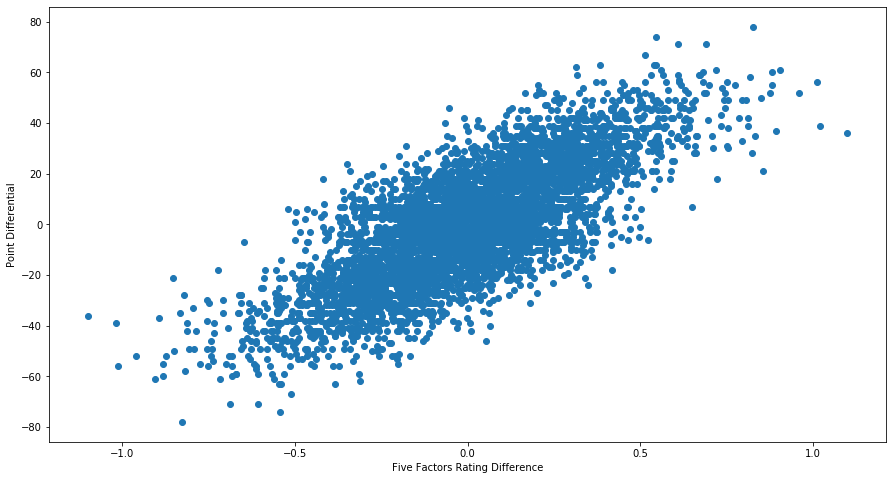

In [344]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [345]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,1.69,0.22,0.706398,-0.106235,0.403923,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,1.47,-0.22,0.812634,0.106235,0.403923,0.903174
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.44,0.22,0.357278,0.076127,0.289447,0.180635
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,0.22,-0.22,0.281151,-0.076127,0.289447,0.180635
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.00,0.071429,0.400000,0.98,-0.22,0.339421,-1.012484,3.849610,2.528887


In [346]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [347]:
outliers

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.000000,0.071429,0.400000,0.98,-0.22,0.339421,-1.012484,3.849610,2.528887
1,Louisville,2016,400869341,70.0,56.0,0.999941,0.681159,0.289855,9.275362,33.866667,4.666667,0.909091,0.733333,0.779661,1.20,0.22,1.351904,1.012484,3.849610,2.528887
0,Hawai'i,2016,400869180,3.0,-60.0,0.000004,0.310345,0.103448,4.241379,27.000000,0.272727,0.250000,0.363636,0.486486,1.42,0.22,0.371772,-0.881703,3.352361,2.709522
1,Michigan,2016,400869180,63.0,60.0,0.999996,0.694915,0.237288,8.694915,27.000000,7.000000,1.000000,0.777778,0.709091,1.20,-0.22,1.253475,0.881703,3.352361,2.709522
0,Bowling Green,2016,400869260,10.0,-67.0,0.000005,0.319444,0.041667,3.388889,22.642857,0.714286,0.500000,0.285714,0.410256,0.66,0.44,0.340262,-0.512154,1.947283,3.025633
1,Ohio State,2016,400869260,77.0,67.0,0.999995,0.641304,0.097826,8.282609,31.615385,5.923077,0.909091,0.846154,0.658824,0.22,-0.44,0.852416,0.512154,1.947283,3.025633
0,Bowling Green,2016,400869287,3.0,-74.0,0.000002,0.297297,0.054054,3.878378,22.647059,0.176471,0.250000,0.235294,0.451613,1.32,0.88,0.356310,-0.544709,2.071061,3.341743
1,Memphis,2016,400869287,77.0,74.0,0.999998,0.472973,0.202703,8.189189,33.588235,4.529412,1.000000,0.588235,0.625000,0.44,-0.88,0.901019,0.544709,2.071061,3.341743
0,Rutgers,2016,400869635,0.0,-58.0,0.000006,0.240741,0.037037,2.222222,19.250000,0.000000,0.000000,0.000000,0.000000,0.49,-0.22,0.140585,-0.817478,3.108170,2.619204
1,Ohio State,2016,400869635,58.0,58.0,0.999994,0.617978,0.146067,7.516854,35.181818,5.272727,0.900000,0.909091,0.621951,0.71,0.22,0.958063,0.817478,3.108170,2.619204


In [348]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,1.69,0.22,0.706398,-0.106235,0.403923,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,1.47,-0.22,0.812634,0.106235,0.403923,0.903174
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.44,0.22,0.357278,0.076127,0.289447,0.180635
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,0.22,-0.22,0.281151,-0.076127,0.289447,0.180635
0,Appalachian State,2016,400868977,13.0,-7.0,0.834594,0.459016,0.049180,4.508197,26.500000,1.083333,0.40,0.416667,0.600000,1.91,-0.88,0.311751,-0.183410,0.697352,0.316111


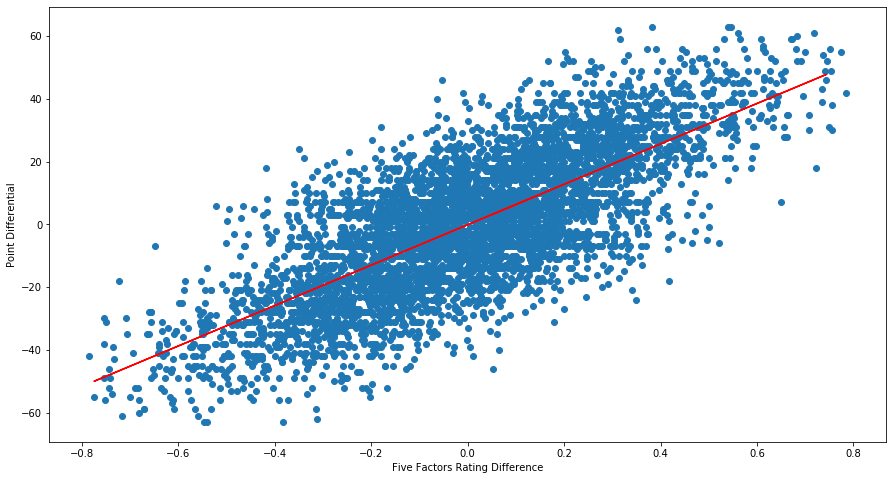

In [349]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [350]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

test = pd.DataFrame({
    'ActPtsDiff':test_data['PtsDiff'],
    'PredPtsDiff' : yfit
})

test.corr()

Linear Regression: y = 64.38262x + -0.11031


,ActPtsDiff,PredPtsDiff
ActPtsDiff,1.000000,0.768852
PredPtsDiff,0.768852,1.000000


In [351]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [352]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
5FRDiff for Virginia Tech: 0.052567774458461725

Proj MOV by 5FRDiff: Virginia Tech by 3.0 (exact value: 3.2741371494791593)
Z score: 0.20251040447964477
Win Prob for Virginia Tech: 58.02%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,1.15,-0.66,0.512424,-0.052568
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,1.81,0.66,0.564992,0.052568


In [353]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
5FRDiff for Georgia Tech: -0.1184291142016603

Proj MOV by 5FRDiff: Georgia Tech by -8.0 (exact value: -7.735090199550593)
Z score: -0.4653337189444258
Win Prob for Georgia Tech: 32.08%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,17.444444,3.111111,0.500000,0.444444,0.47619,0.93,-0.66,0.481263,-0.118429
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,38.750000,1.750000,0.333333,0.750000,0.40000,1.59,0.66,0.599692,0.118429


In [354]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
5FRDiff for Georgia Tech: 0.030736975176983372

Proj MOV by 5FRDiff: Georgia Tech by 2.0 (exact value: 1.8686131403345416)
Z score: 0.11724820395642657
Win Prob for Georgia Tech: 54.67%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,23.700000,2.600000,0.833333,0.600000,0.552239,0.98,0.0,0.655222,-0.030737
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,29.636364,2.545455,0.571429,0.636364,0.571429,0.98,0.0,0.685959,0.030737


In [355]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
5FRDiff for Mississippi State: 0.048901702816578796

Proj MOV by 5FRDiff: Mississippi State by 3.0 (exact value: 3.038105859672818)
Z score: 0.18819222348075196
Win Prob for Mississippi State: 57.46%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,25.545455,1.818182,0.60,0.454545,0.473684,1.20,0.22,0.508653,-0.048902
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,31.333333,1.750000,0.75,0.333333,0.533333,0.98,-0.22,0.557555,0.048902


In [356]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
5FRDiff for Texas A&M: -0.035671978147348016

Proj MOV by 5FRDiff: Texas A&M by -2.0 (exact value: -2.4069691283688717)
Z score: -0.14211808959380876
Win Prob for Texas A&M: 44.35%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,46.176471,4.235294,0.916667,0.705882,0.520548,0.49,0.0,0.707957,0.035672
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,45.157895,3.894737,0.923077,0.684211,0.505882,0.49,0.0,0.672285,-0.035672


In [363]:
stored_game_boxes[stored_game_boxes.isnull().any(axis=1)]

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score


In [364]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
    print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]['5FRDiff'].mean()
    pred = model.predict([[tester]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

team_wp_frame = pd.DataFrame()
for team in team_list:
    team_wp_frame = team_wp_frame.append(pd.DataFrame({
        'team':[team],
        'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
    }))
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * 12.0)
team_wp_frame['proj_losses'] = 12 - team_wp_frame['proj_wins']
team_wp_frame.sort_values(by=['avg_win_prob'], ascending=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].mean()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(f"rating diff is {ffr_diff}")
    pred = model.predict([[ffr_diff]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
#     print(f"{team1} should beat {team2} by {pred[0]} and should win {(100 * win_prob):.2f}% of the time")
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

In [ ]:
team_triples = [
    ['Texas','Texas Tech',9.5],
    ['Virginia Tech','Virginia',2.5],
    ['Iowa','Nebraska',5.5],
    ['Missouri','Arkansas',11.5],
    ['Memphis','Cincinnati',11.5],
    ['Washington','Washington State',7.5],
    ['Georgia','Georgia Tech',28.5],
    ['Kentucky','Louisville',2.5],
    ['Clemson', 'South Carolina',27.5],
    ['Ohio State','Michigan',8.5],
    ['Indiana','Purdue',7.5],
    ['Miami','Duke',7.5],
    ['Wisconsin','Minnesota',2.5],
    ['Alabama','Auburn',3.5],
    ['Tennessee','Vanderbilt',22.5],
    ['Oregon','Oregon State',19.5],
    ['Notre Dame','Stanford',16.5],
    ['North Carolina','NC State',7.5],
    ['LSU','Texas A&M',16.5],
    ['Florida','Florida State',17.5],
    ['Utah','Colorado',17.5],
    ['Oklahoma','Oklahoma State',13.5],
    ['Arizona State','Arizona',13.5],
    ['Hawai\'i','Army',3.5]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "team": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_win_prob'], ascending=False)

In [ ]:
# generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)
# testerframe = pd.read_json(retrieveRemoteCfbGame(401112521, 2019))